In [1]:
import torch
import cmws.util
import cmws.examples.timeseries.util as timeseries_util
import cmws.examples.timeseries.data as data
from cmws.examples.timeseries import run
import matplotlib.pyplot as plt
import cmws.examples.timeseries.inference
from cmws.examples.timeseries import lstm_util
import textwrap
from cmws import losses


def get_num_base_kernels(raw_expression, eos):
    """
    Args:
        raw_expression [*shape, max_num_chars]
        eos [*shape, max_num_chars]

    Returns: [*shape]
    """
    # Extract
    device = raw_expression.device
    max_num_chars = raw_expression.shape[-1]
    shape = raw_expression.shape[:-1]
    num_elements = cmws.util.get_num_elements(shape)

    # Flatten
    raw_expression_flattened = raw_expression.view(-1, max_num_chars)
    eos_flattened = eos.view(-1, max_num_chars)

    # Compute num timesteps
    # [num_elements]
    num_timesteps_flattened = lstm_util.get_num_timesteps(eos_flattened)

    result = []
    for element_id in range(num_elements):
        result.append(
            timeseries_util.count_base_kernels(
                raw_expression_flattened[element_id, : num_timesteps_flattened[element_id]]
            )
        )
    return torch.tensor(result, device=device).long().view(shape)


def get_full_expression(raw_expression, eos, raw_gp_params):
    num_chars = lstm_util.get_num_timesteps(eos)
    num_base_kernels = get_num_base_kernels(
        raw_expression, eos
    )
    long_expression = timeseries_util.get_long_expression(
        timeseries_util.get_expression(
            raw_expression[: num_chars]
        )
    )
    try:
        kernel = timeseries_util.Kernel(
            timeseries_util.get_expression(raw_expression[: num_chars]),
            raw_gp_params[ : num_base_kernels],
        )
        return timeseries_util.get_long_expression_with_params(timeseries_util.get_expression(raw_expression[: num_chars]), kernel.params)
    except timeseries_util.ParsingError as e:
        print(e)
        return long_expression


def plot_obs(ax, obs):
    """
    Args
        ax
        obs [num_timesteps]
    """
    if torch.is_tensor(obs):
        obs = obs.cpu().numpy()
    ax.plot(obs, color="C0")
    ax.set_ylim(-4, 4)
    ax.set_xticks([])
    ax.set_yticks([-4, 4])
    ax.tick_params(axis="y", direction="in")

    
    
def plot_predictions_timeseries(generative_model, guide, obs, memory=None, obs_id=None):
    """
    Args:
        generative_model
        guide
        obs: [num_test_obs, num_timesteps]
        memory
        obs_id
    """
    num_samples = 1
    num_test_obs, num_timesteps = obs.shape
    assert num_test_obs == 1

    # Sample latent
    num_svi_iterations = 1
    if memory is None:
        num_particles = 5
        latent, log_weight = cmws.examples.timeseries.inference.svi_importance_sampling(
            num_particles, num_svi_iterations, obs, generative_model, guide
        )
    else:
        assert obs_id is not None
        num_particles = memory.size
        # latent, log_weight = cmws.examples.timeseries.inference.svi_memory(
        #     num_svi_iterations, obs, obs_id, generative_model, guide, memory
        # )
        latent, log_weight = cmws.examples.timeseries.inference.importance_sample_memory(
            num_particles, num_svi_iterations, obs, obs_id, generative_model, guide, memory
        )
    x, eos, raw_gp_params = latent
    num_chars = lstm_util.get_num_timesteps(eos)

    # Sort by log weight
    # [num_test_obs, num_particles], [num_test_obs, num_particles]
    _, sorted_indices = torch.sort(log_weight.T, descending=True)

    # Sample predictions
    # -- Expand obs
    obs_expanded = obs[None].expand(num_particles, num_test_obs, num_timesteps)

    # -- Sample predictions
    obs_predictions = generative_model.sample_obs_predictions(latent, obs_expanded, [num_samples])

    # Plot
    num_rows = num_test_obs
    num_cols = num_particles
    fig, axss = plt.subplots(
        num_rows,
        num_cols,
        figsize=(3 * num_cols, 2 * num_rows),
        sharex=True,
        sharey=True,
        squeeze=False,
    )

    for test_obs_id in range(num_test_obs):
        for particle_id in range(num_particles):
            # Plot obs
            ax = axss[test_obs_id, particle_id]
            plot_obs(ax, obs[test_obs_id])

            # Compute sorted particle id
            sorted_particle_id = sorted_indices[test_obs_id, particle_id]

            long_expression = get_full_expression(x[sorted_particle_id, test_obs_id], eos[sorted_particle_id, test_obs_id], raw_gp_params[sorted_particle_id, test_obs_id])
            ax.text(
                0.05,
                0.95,
                "\n".join(textwrap.wrap(long_expression, 20)),
                transform=ax.transAxes,
                fontsize=7,
                va="top",
                ha="left",
                color="black",
            )
            ax.text(
                0.95,
                0.95,
                f"{log_weight[sorted_particle_id, test_obs_id].item():.0f}",
                transform=ax.transAxes,
                fontsize=7,
                va="top",
                ha="right",
                color="black",
            )
            for sample_id in range(num_samples):
                ax.plot(
                    torch.arange(data.num_timesteps, 2 * data.num_timesteps).float(),
                    obs_predictions[sample_id, sorted_particle_id, test_obs_id].cpu().detach(),
                    color="C1",
                    alpha=0.5,
                )
        
def get_obs_log_prob(raw_expression, eos, gp_raw_params, obs):
    x_1 = torch.linspace(-2, 2, steps=256, device=device)[
        None, :, None
    ].expand(1, 256, 1)
    x_2 = torch.linspace(-2, 2, steps=256, device=device)[
        None, None, :
    ].expand(1, 1, 256)

    num_chars = lstm_util.get_num_timesteps(eos)
    num_base_kernels = get_num_base_kernels(
        raw_expression, eos
    )
    kernel = timeseries_util.Kernel(
        timeseries_util.get_expression(raw_expression[: num_chars]),
        gp_raw_params[ : num_base_kernels],
    )
    cov = kernel(x_1, x_2)
    return cmws.util.get_multivariate_normal_dist(torch.zeros(1, 256, device=device), cov).log_prob(obs)

# Init and pretrain

22:33:29 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws_refactor/cmws/util.py:310 | INFO: Using CUDA
22:33:30 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws_refactor/cmws/examples/timeseries/data.py:38 | INFO: Loaded 36795 timeseries
22:33:36 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws_refactor/cmws/examples/timeseries/expression_prior_pretraining.py:33 | INFO: Pretraining the expression prior


100%|██████████| 2000/2000 [00:24<00:00, 80.36it/s]

22:34:01 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws_refactor/cmws/memory.py:20 | INFO: Initializing memory



100%|██████████| 1/1 [00:00<00:00, 16.58it/s]


22:34:02 | <ipython-input-2-4ed022cf9e3b>:66 | INFO: Sleep Pretraining Iteration 0 | Loss = 22 | Max GPU memory allocated = 59 MB
22:34:03 | <ipython-input-2-4ed022cf9e3b>:66 | INFO: Sleep Pretraining Iteration 1 | Loss = 19 | Max GPU memory allocated = 64 MB
22:34:03 | <ipython-input-2-4ed022cf9e3b>:66 | INFO: Sleep Pretraining Iteration 2 | Loss = 18 | Max GPU memory allocated = 64 MB
22:34:04 | <ipython-input-2-4ed022cf9e3b>:66 | INFO: Sleep Pretraining Iteration 3 | Loss = 21 | Max GPU memory allocated = 64 MB
22:34:04 | <ipython-input-2-4ed022cf9e3b>:66 | INFO: Sleep Pretraining Iteration 4 | Loss = 20 | Max GPU memory allocated = 64 MB
22:34:05 | <ipython-input-2-4ed022cf9e3b>:66 | INFO: Sleep Pretraining Iteration 5 | Loss = 22 | Max GPU memory allocated = 64 MB
22:34:06 | <ipython-input-2-4ed022cf9e3b>:66 | INFO: Sleep Pretraining Iteration 6 | Loss = 24 | Max GPU memory allocated = 64 MB
22:34:06 | <ipython-input-2-4ed022cf9e3b>:66 | INFO: Sleep Pretraining Iteration 7 | Loss 

22:34:35 | <ipython-input-2-4ed022cf9e3b>:66 | INFO: Sleep Pretraining Iteration 63 | Loss = 18 | Max GPU memory allocated = 64 MB
22:34:35 | <ipython-input-2-4ed022cf9e3b>:66 | INFO: Sleep Pretraining Iteration 64 | Loss = 18 | Max GPU memory allocated = 64 MB
22:34:36 | <ipython-input-2-4ed022cf9e3b>:66 | INFO: Sleep Pretraining Iteration 65 | Loss = 18 | Max GPU memory allocated = 64 MB
22:34:36 | <ipython-input-2-4ed022cf9e3b>:66 | INFO: Sleep Pretraining Iteration 66 | Loss = 19 | Max GPU memory allocated = 64 MB
22:34:37 | <ipython-input-2-4ed022cf9e3b>:66 | INFO: Sleep Pretraining Iteration 67 | Loss = 19 | Max GPU memory allocated = 64 MB
22:34:37 | <ipython-input-2-4ed022cf9e3b>:66 | INFO: Sleep Pretraining Iteration 68 | Loss = 17 | Max GPU memory allocated = 64 MB
22:34:38 | <ipython-input-2-4ed022cf9e3b>:66 | INFO: Sleep Pretraining Iteration 69 | Loss = 17 | Max GPU memory allocated = 64 MB
22:34:38 | <ipython-input-2-4ed022cf9e3b>:66 | INFO: Sleep Pretraining Iteration 70

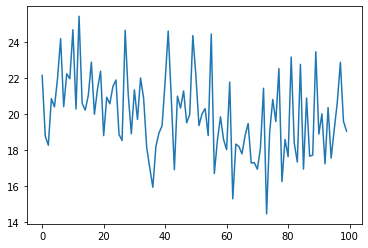

In [2]:
args = run.get_args_parser().parse_args([])
args.experiment_name = "bla"
args.seed = 0
args.full_training_data = True
args.num_particles = 10
args.insomnia = 0.5
args.algorithm = "cmws_2"
args.continue_training = True
args.memory_size = 5
args.num_sleep_pretraining_iterations = 100
args.sleep_pretraining_batch_size = 50

device = cmws.util.get_device()

# Data
train_dataset = data.TimeseriesDataset(device, False, full_data=args.full_training_data)
obs, obs_id = train_dataset[29:30]
obs_id *= 0

# Model
old_algorithm = args.algorithm
args.algorithm = "bla"
model, optimizer, stats = timeseries_util.init(args, device)
generative_model, guide, memory = (
    model["generative_model"],
    model["guide"],
    model["memory"],
)
memory = cmws.memory.Memory(
    1,
    args.memory_size,
    generative_model
).to(device)
args.algorithm = old_algorithm


# Sleep pretraining
if "sleep_pretraining_batch_size" in args:
    if args.sleep_pretraining_batch_size == 0:
        sleep_pretraining_batch_size = args.num_particles * args.batch_size
    else:
        sleep_pretraining_batch_size = args.sleep_pretraining_batch_size
else:
    sleep_pretraining_batch_size = args.num_particles * args.batch_size
for iteration in range(args.num_sleep_pretraining_iterations):
    # Zero grad
    optimizer.zero_grad()

    # Evaluate loss
    loss = losses.get_sleep_loss(
        generative_model, guide, sleep_pretraining_batch_size
    ).mean()

    # Compute gradient
    loss.backward()

    # Step gradient
    optimizer.step()

    # Record stats
    stats.sleep_pretraining_losses.append(loss.item())

    # Log
    if iteration % args.log_interval == 0:
        cmws.util.logging.info(
            f"Sleep Pretraining Iteration {iteration} | "
            f"Loss = {stats.sleep_pretraining_losses[-1]:.0f} | "
            f"Max GPU memory allocated = {cmws.util.get_max_gpu_memory_allocated_MB(device):.0f} MB"
        )
plt.plot(stats.sleep_pretraining_losses)

# Main training loop

0 | 575984.6875 | -362.3258056640625 | 2563655.0


/om/user/tuananh/anaconda3/lib/python3.7/site-packages/torch/nn/modules/rnn.py:577: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629427478/work/aten/src/ATen/native/cudnn/RNN.cpp:1264.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/om/user/tuananh/anaconda3/lib/python3.7/site-packages/torch/nn/modules/rnn.py:580: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629427478/work/aten/src/ATen/native/cudnn/RNN.cpp:1234.)
  self.num_layers, self.dropout, self.training, self.bidirectional)


Cannot parse char: 


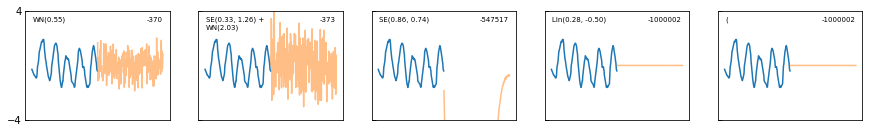

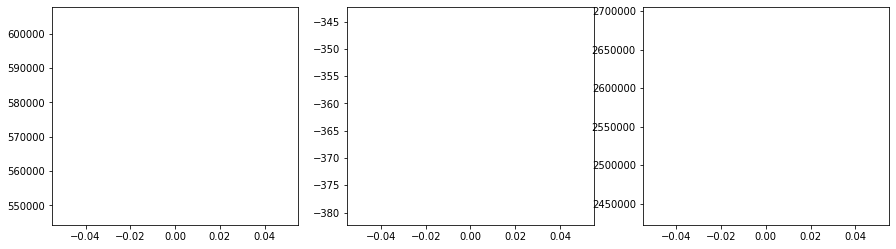

10 | 304.35345458984375 | -191.2129364013672 | 1795306.0


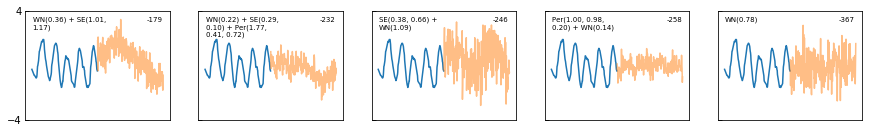

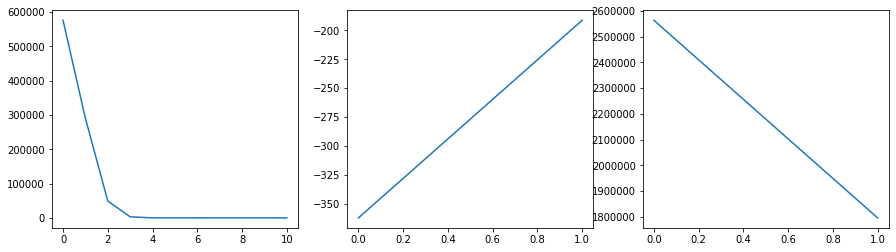

20 | 221.34780883789062 | -79.79576873779297 | 1466690.75


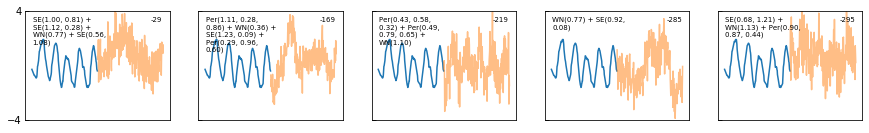

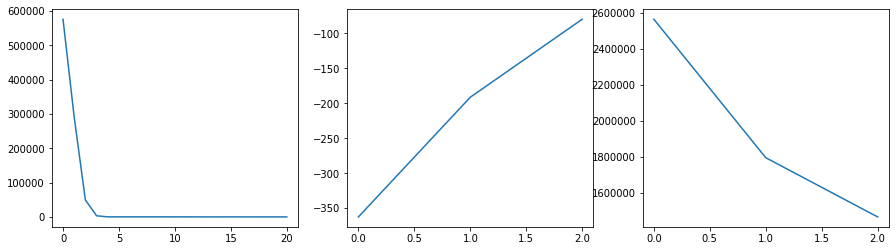

30 | 72.28081512451172 | 182.00929260253906 | 1505284.0


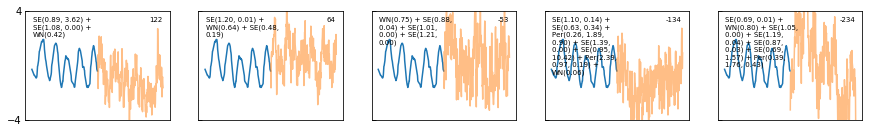

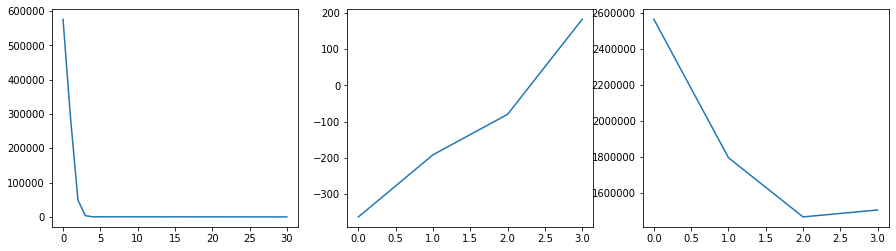

40 | -38.0052490234375 | 167.67918395996094 | 1408599.125


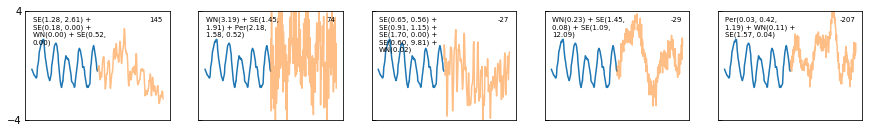

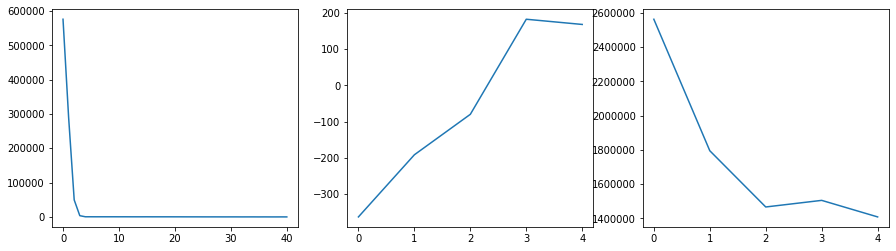

50 | 5.6559906005859375 | 183.0087127685547 | 691272.0


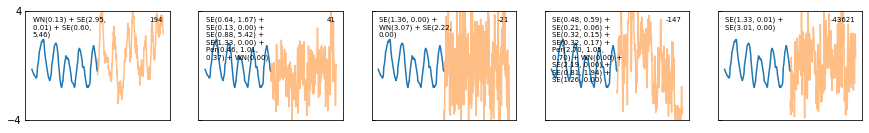

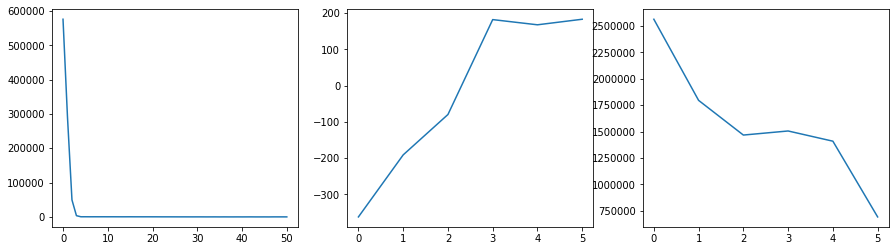

60 | 42.096343994140625 | 159.6815643310547 | 532581.0625


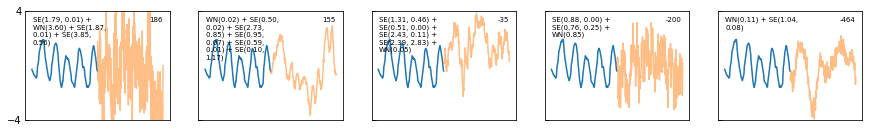

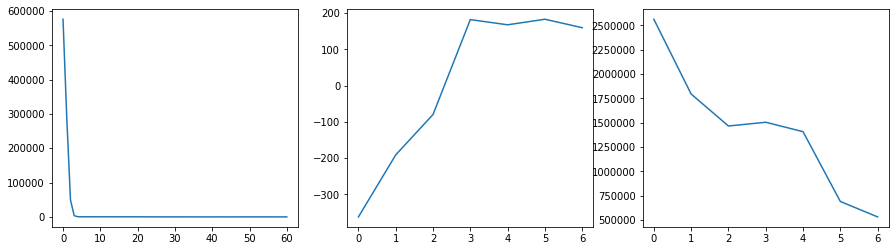

70 | -7.580577850341797 | 172.5177764892578 | 183749.71875


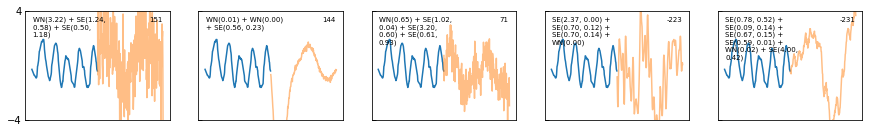

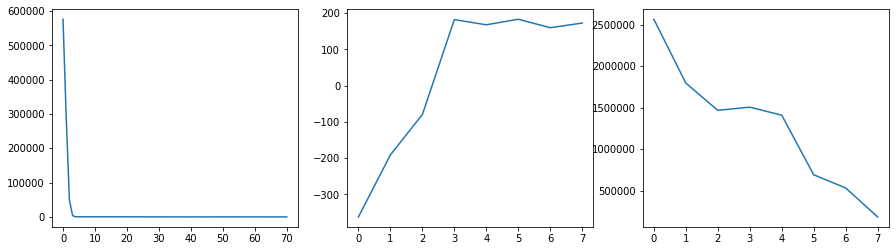

80 | 21.751754760742188 | 195.94400024414062 | 449154.96875


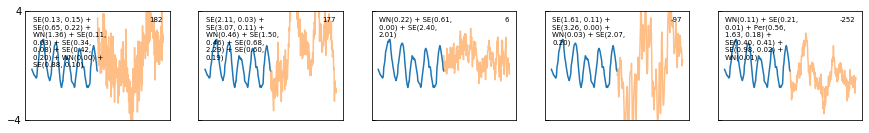

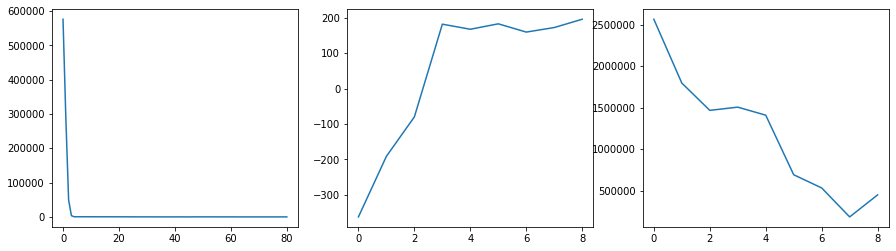

90 | -13.473228454589844 | 200.4158172607422 | 220101.84375


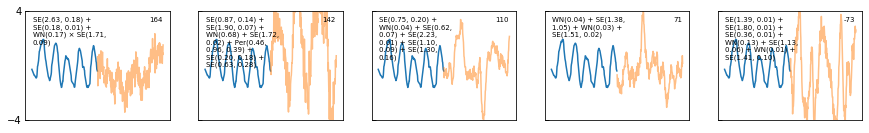

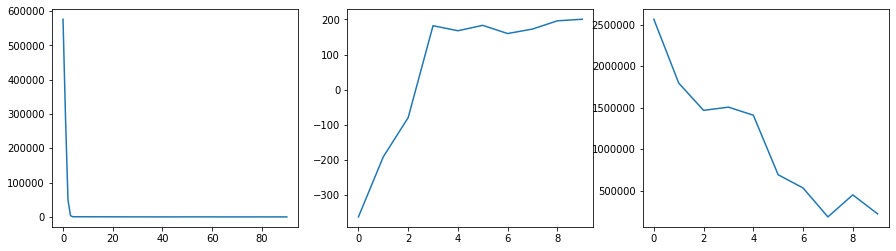

100 | -54.20085144042969 | 196.83055114746094 | 136761.8125


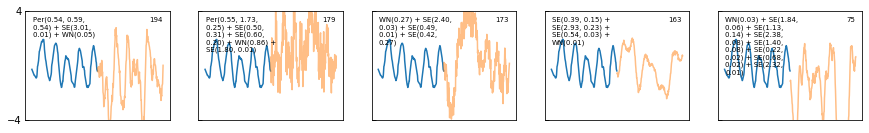

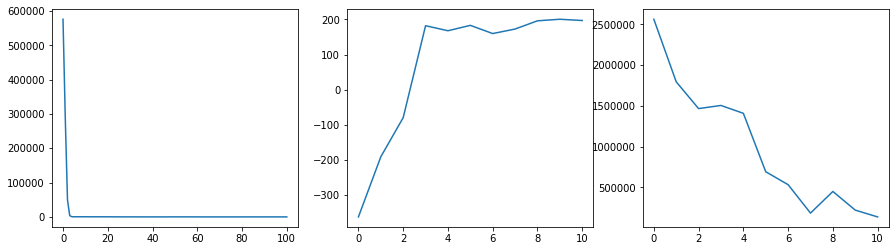

110 | -1.3970565795898438 | 207.6923828125 | 113682.171875


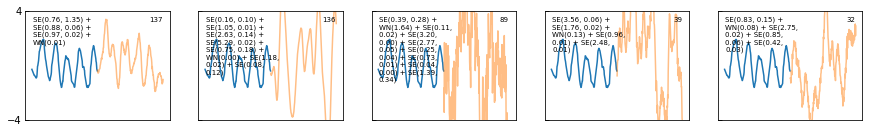

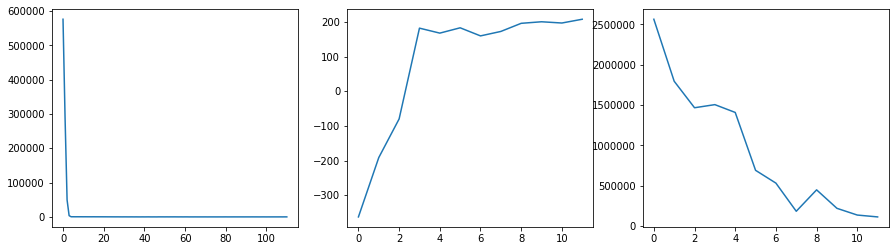

120 | -16.50176239013672 | 210.20602416992188 | 304660.03125


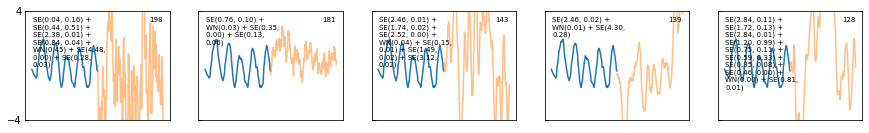

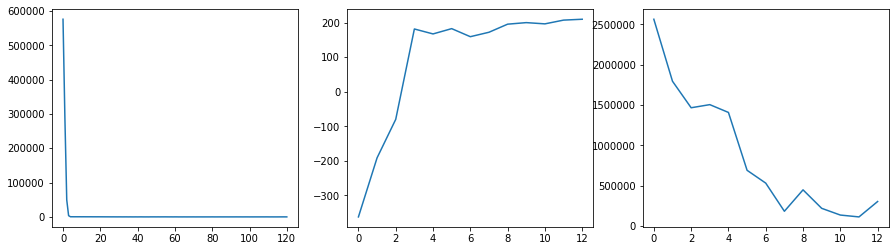

130 | -36.646881103515625 | 221.63963317871094 | 274544.59375


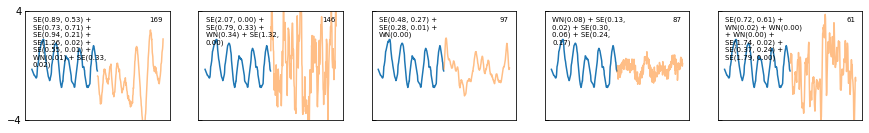

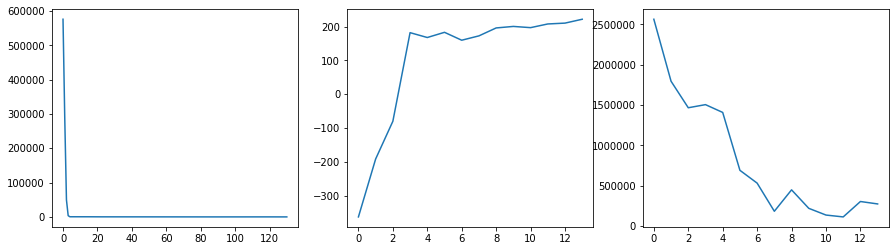

140 | -45.535804748535156 | 214.41246032714844 | 166409.921875


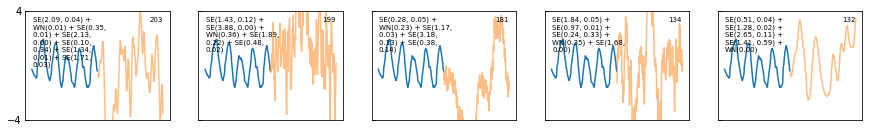

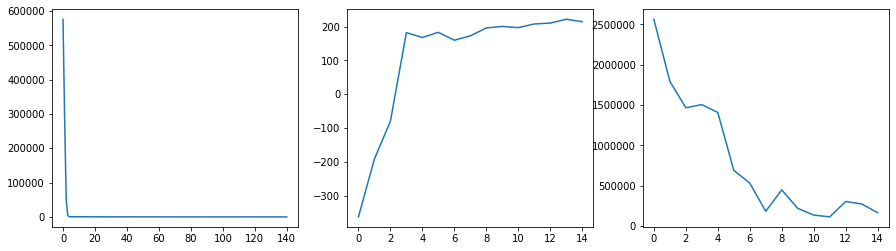

150 | -40.44707489013672 | 211.41319274902344 | 262356.25


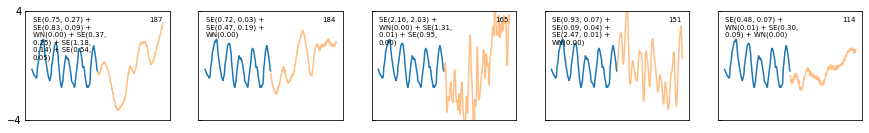

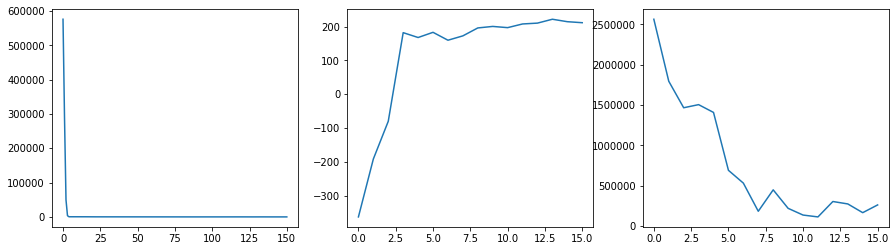

160 | -31.42908477783203 | 210.19454956054688 | 174854.328125


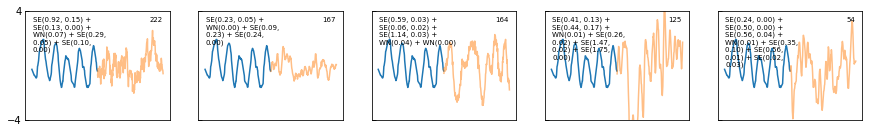

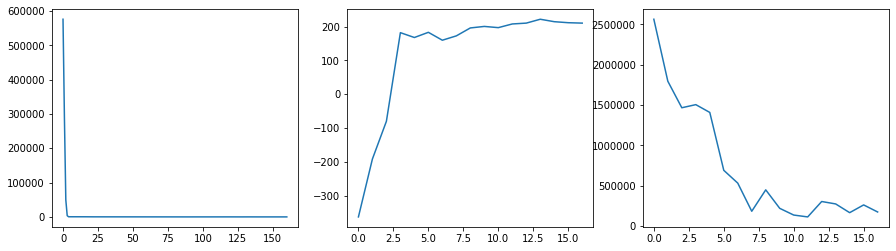

170 | 13.277847290039062 | 218.76783752441406 | 974147.75


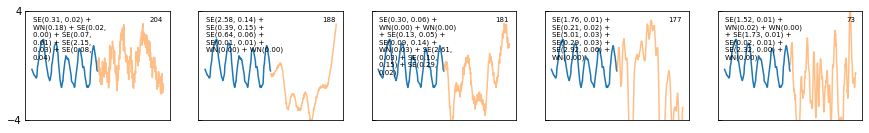

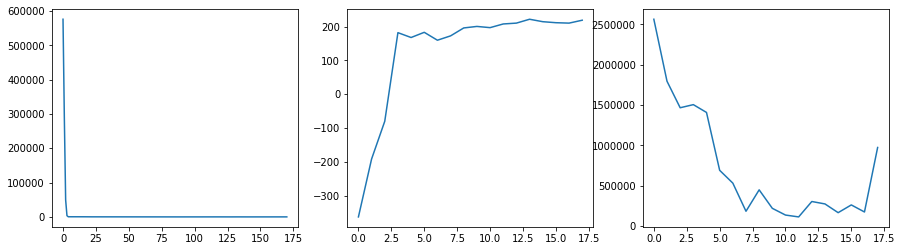

180 | -76.44886016845703 | 232.876220703125 | 92329.4921875


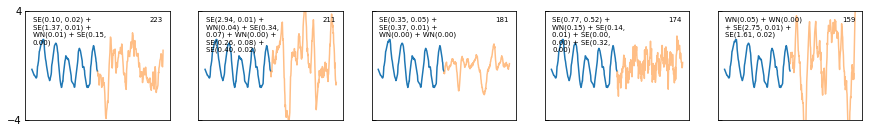

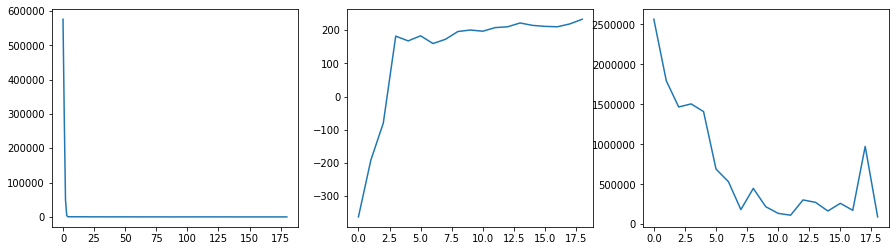

190 | -71.27816772460938 | 234.11712646484375 | 112149.9921875


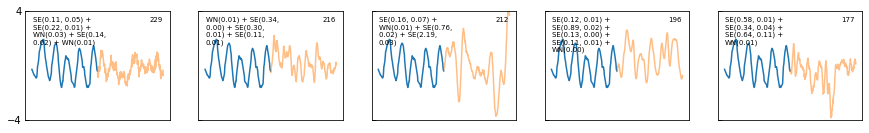

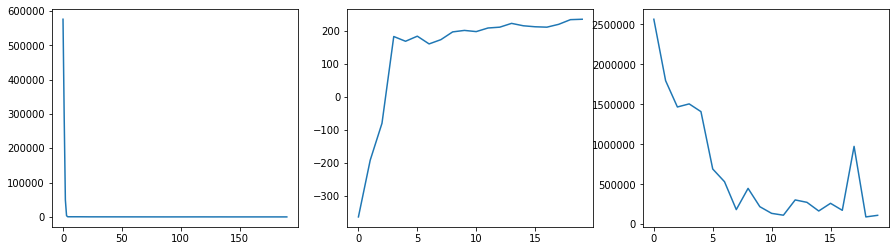

200 | -52.785675048828125 | 225.35824584960938 | 529396.75


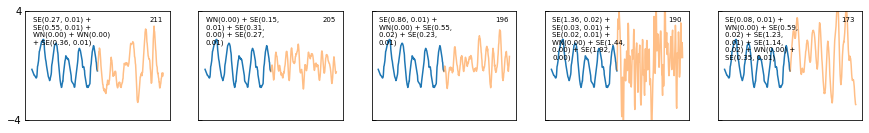

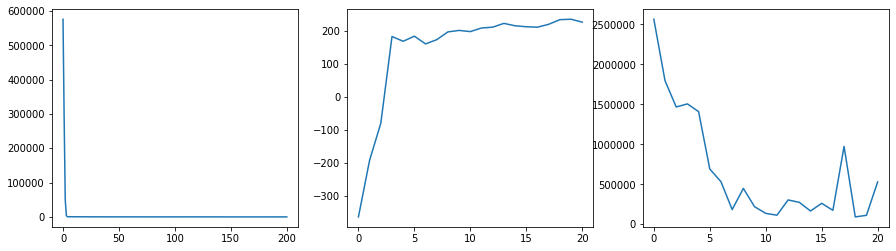

210 | -76.18895721435547 | 227.6695098876953 | 96865.9296875


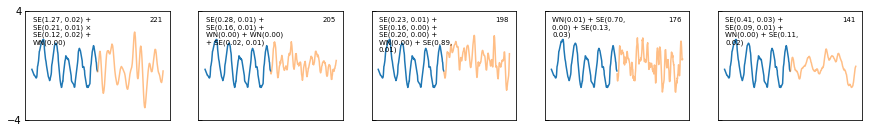

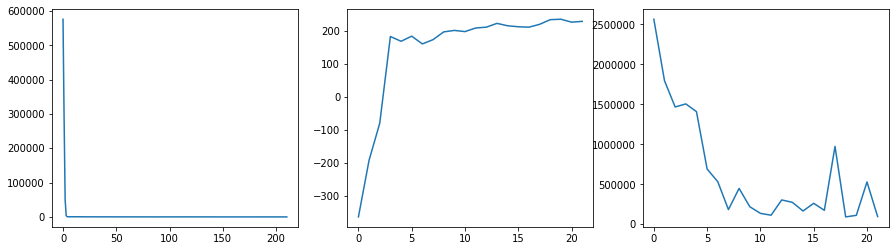

220 | -47.49754333496094 | 233.55345153808594 | 183486.140625


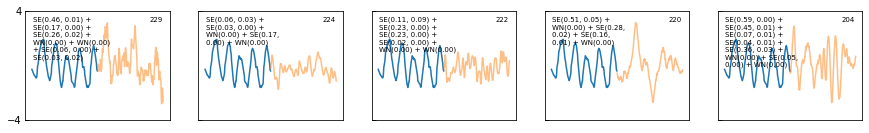

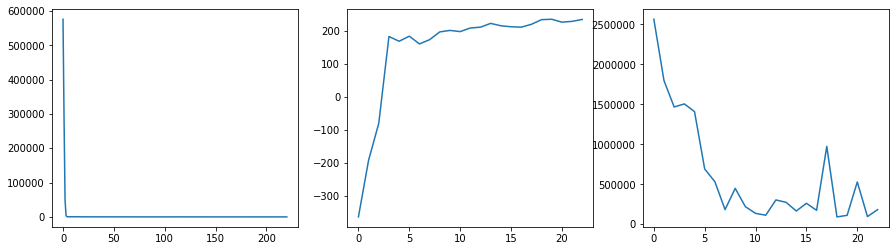

230 | -5.942474365234375 | 243.18368530273438 | 291412.5


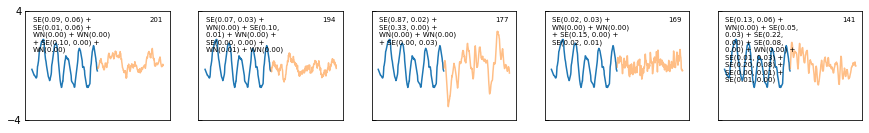

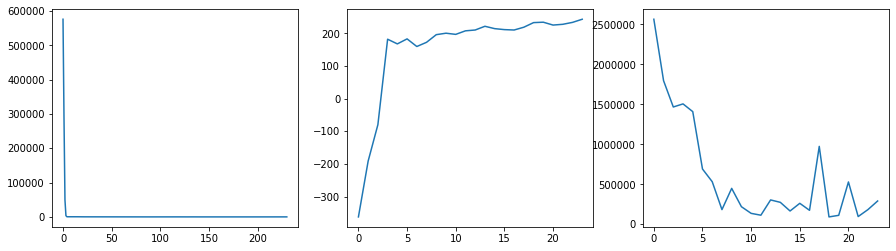

240 | -47.82177734375 | 249.62049865722656 | 80245.953125


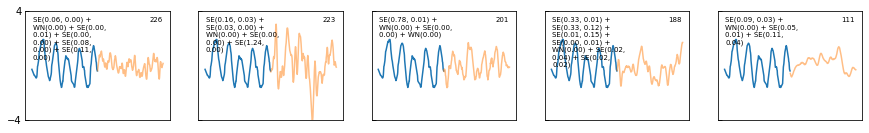

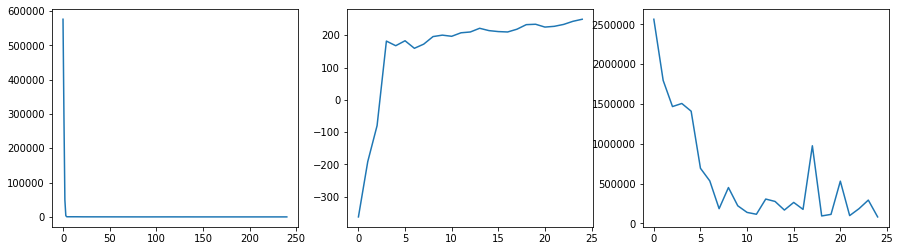

250 | -59.467132568359375 | 247.01083374023438 | 125427.953125


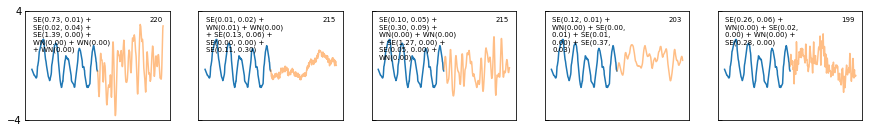

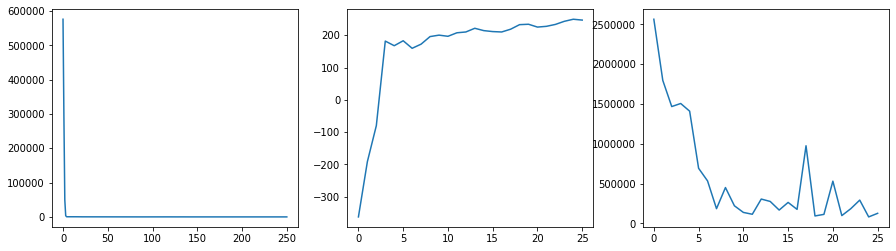

260 | -54.173126220703125 | 243.8548126220703 | 107978.4296875


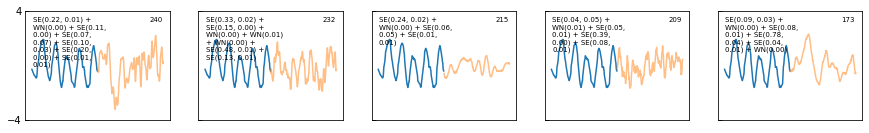

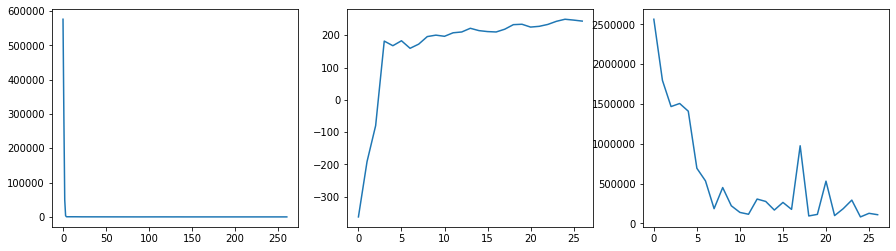

270 | -66.39974975585938 | 246.06881713867188 | 345436.65625


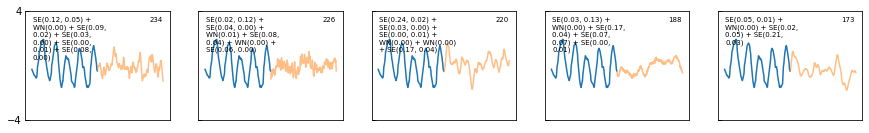

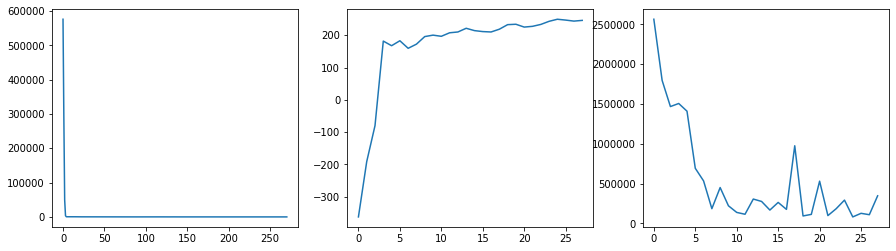

280 | -9.708534240722656 | 248.80410766601562 | 134753.546875


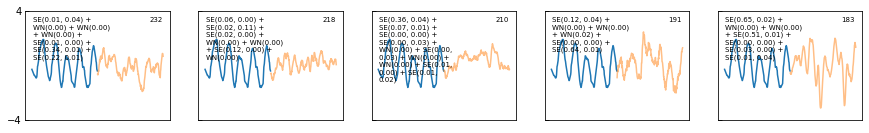

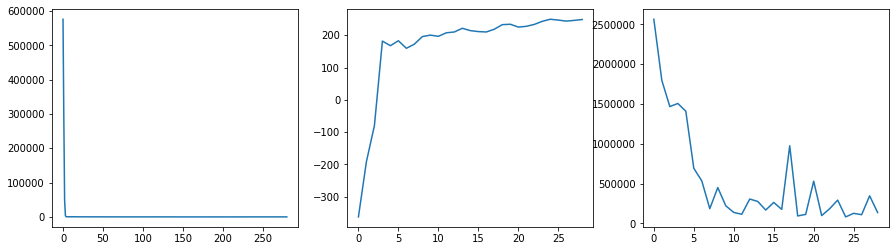

290 | -69.06753540039062 | 241.13768005371094 | 116379.1953125


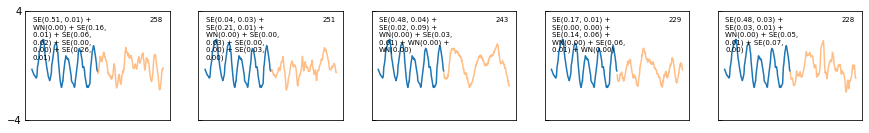

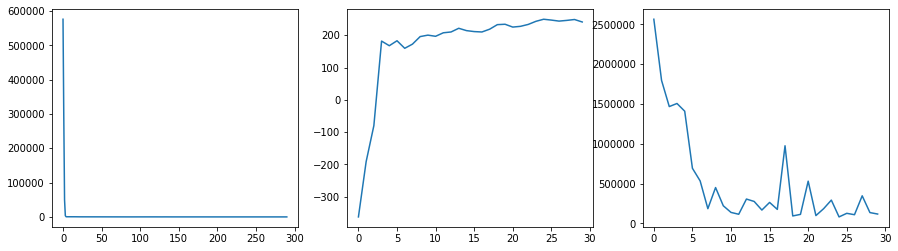

300 | -12.051116943359375 | 257.3354187011719 | 82220.296875


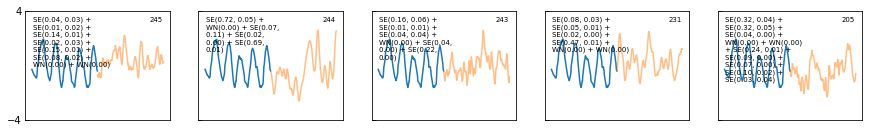

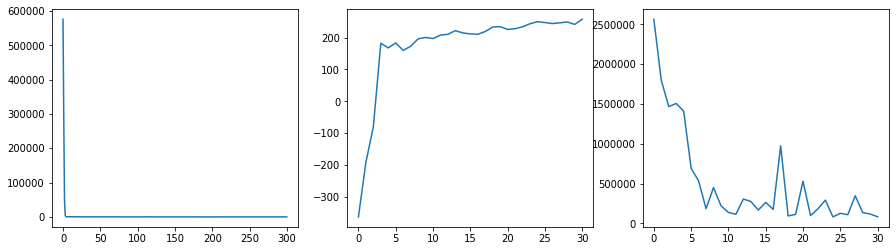

310 | -76.15699768066406 | 234.80657958984375 | 88405.203125


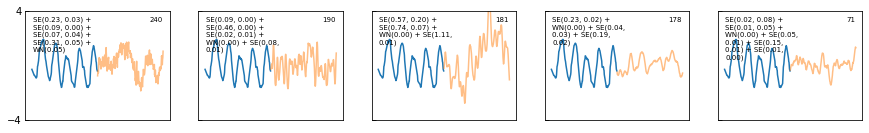

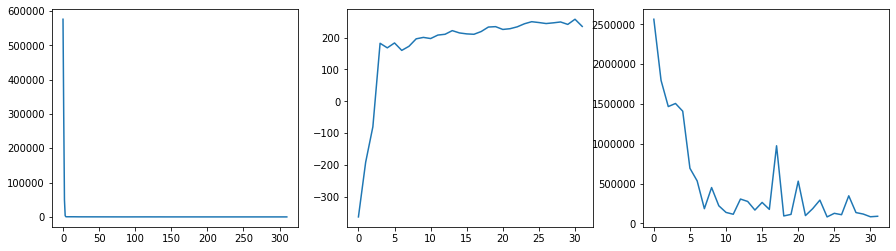

320 | -50.6143798828125 | 264.3405456542969 | 84951.7421875


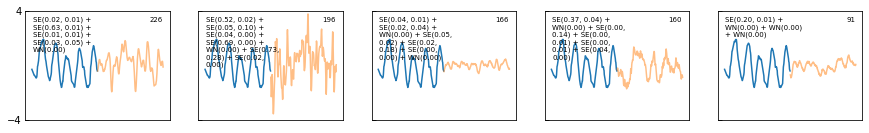

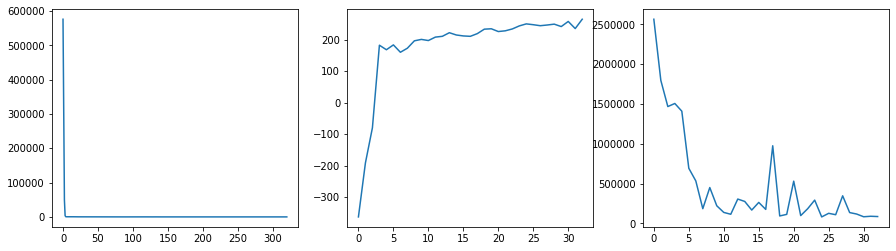

330 | -72.12687683105469 | 242.775146484375 | 68177.25


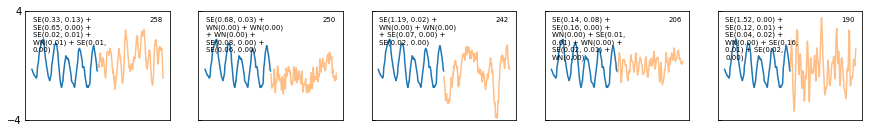

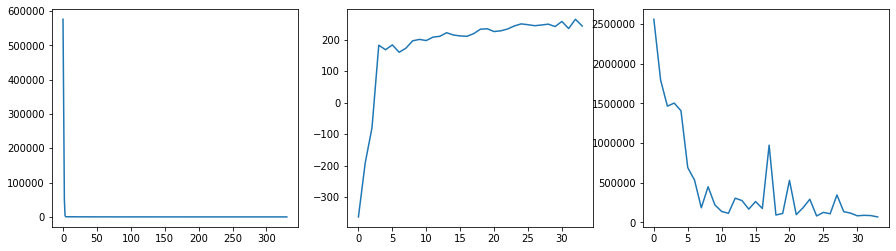

340 | -27.016769409179688 | 256.6140441894531 | 213224.96875


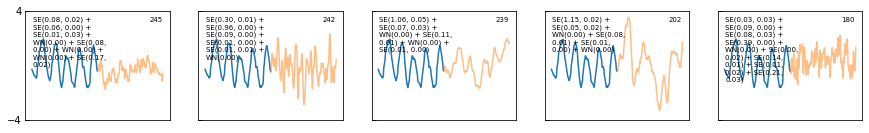

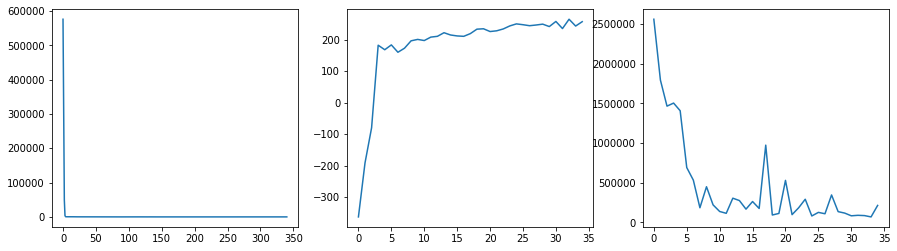

350 | -47.55340576171875 | 249.4585418701172 | 101383.921875


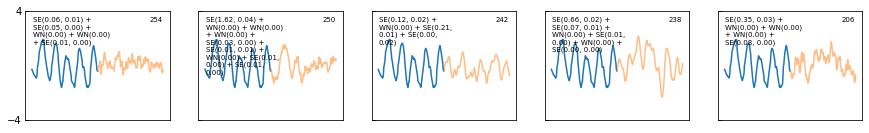

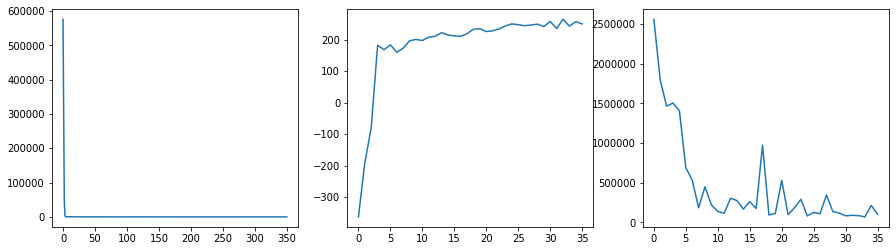

360 | -90.05208587646484 | 265.0228271484375 | 52727.97265625


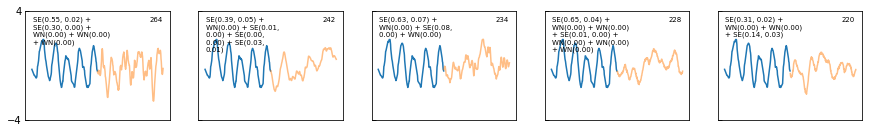

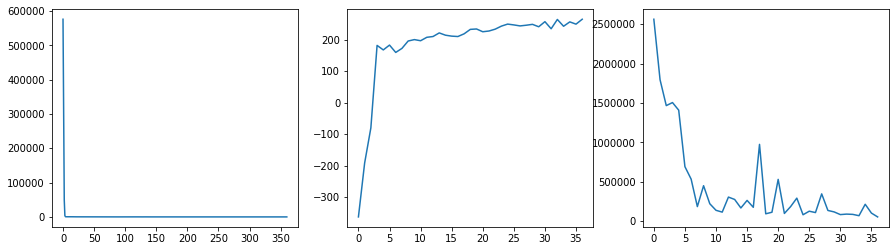

370 | -60.181068420410156 | 259.0708923339844 | 89646.28125


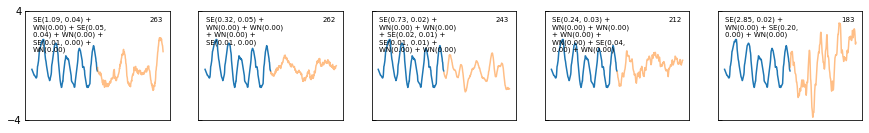

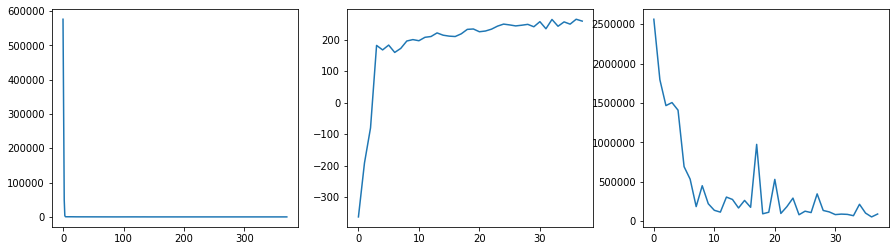

380 | -100.50798034667969 | 264.3144226074219 | 52531.23046875


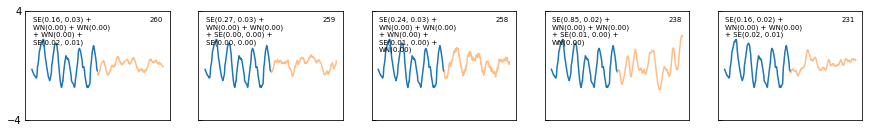

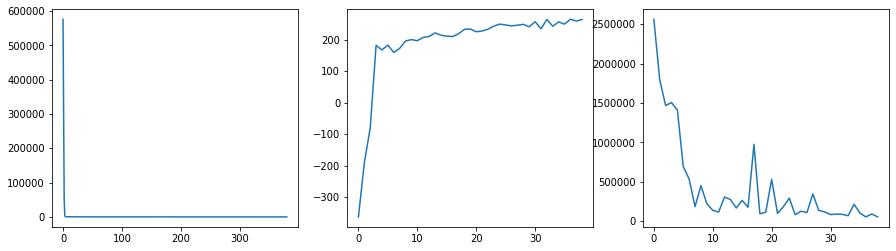

390 | -91.13526916503906 | 266.066162109375 | 43039.8203125


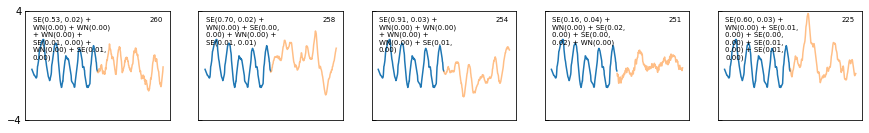

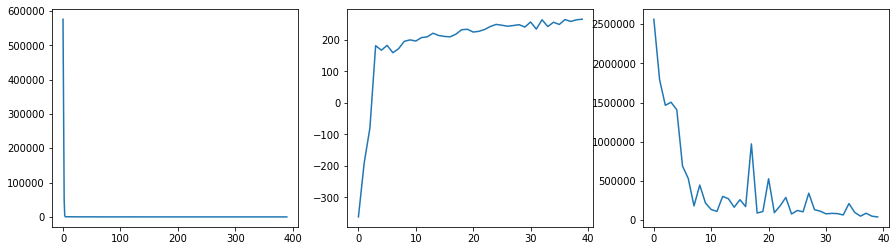

400 | -115.04560089111328 | 270.9287109375 | 109993.234375


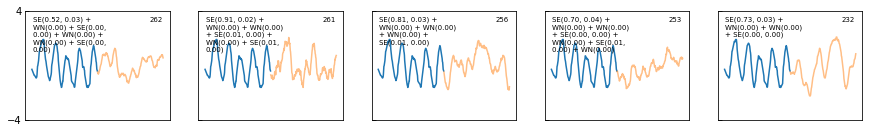

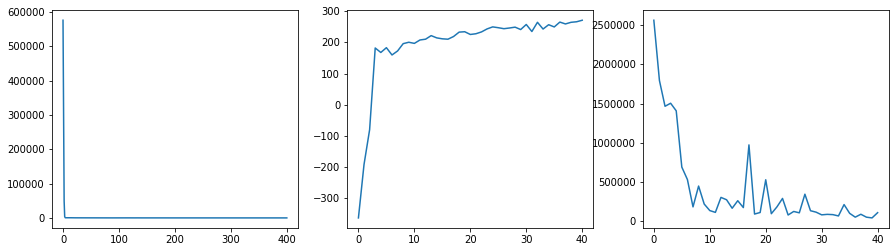

410 | -119.16155242919922 | 270.7860412597656 | 37908.74609375


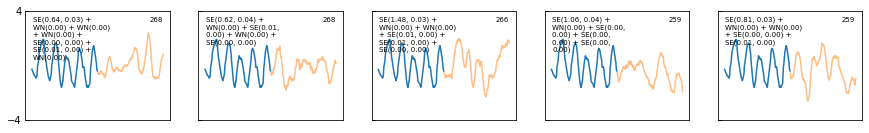

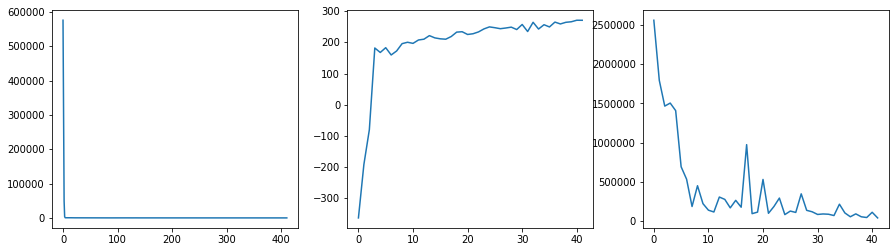

420 | -109.637939453125 | 269.9759826660156 | 81501.03125


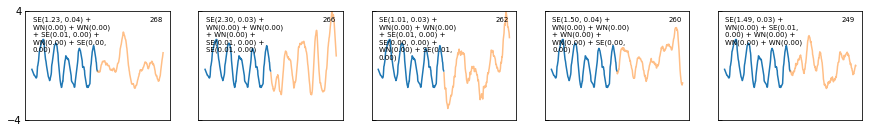

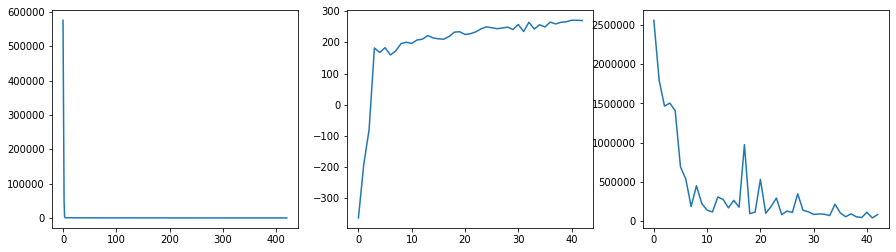

430 | -131.50498962402344 | 270.88043212890625 | 63817.9140625


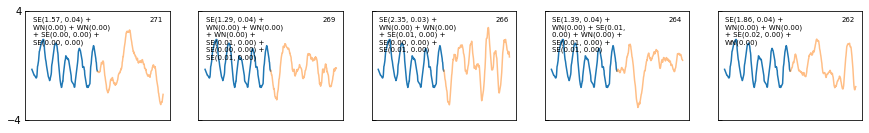

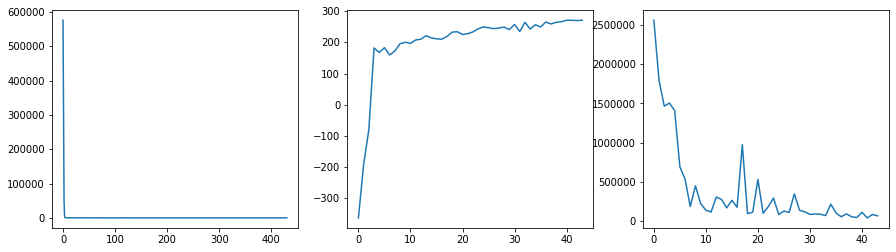

440 | -129.86318969726562 | 270.9606628417969 | 44260.91015625


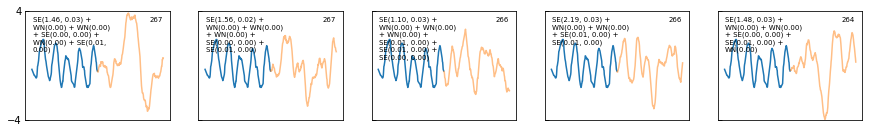

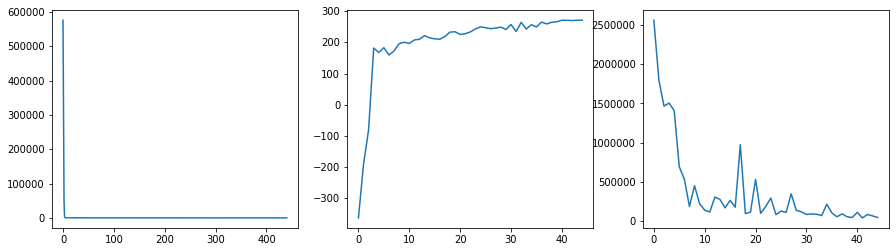

450 | -98.25440979003906 | 272.14959716796875 | 100930.265625


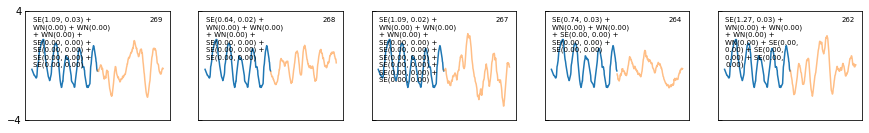

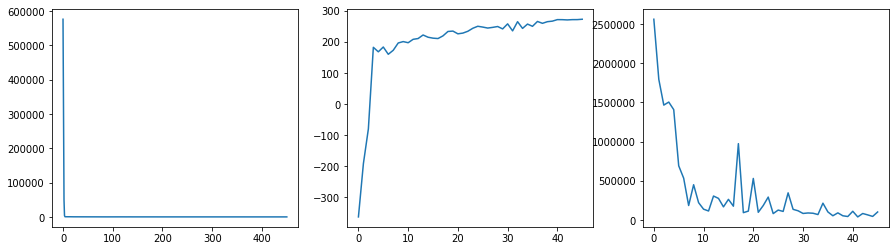

460 | -83.2567367553711 | 271.7965087890625 | 151743.25


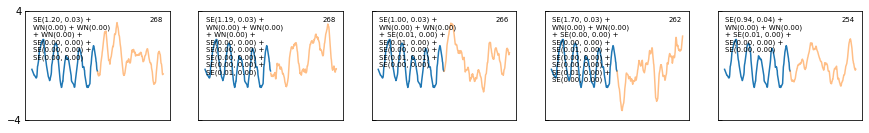

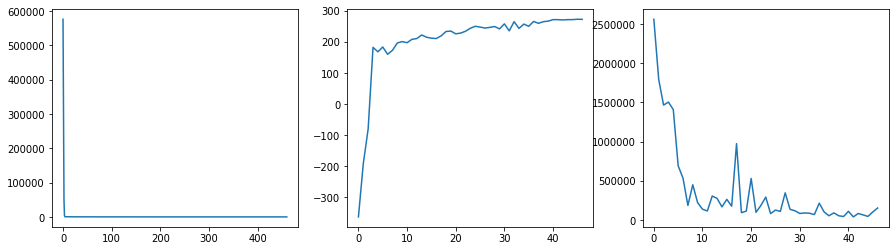

470 | -101.6358642578125 | 270.9772644042969 | 130054.765625


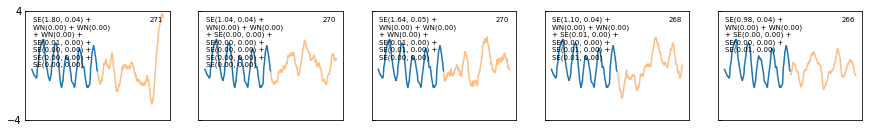

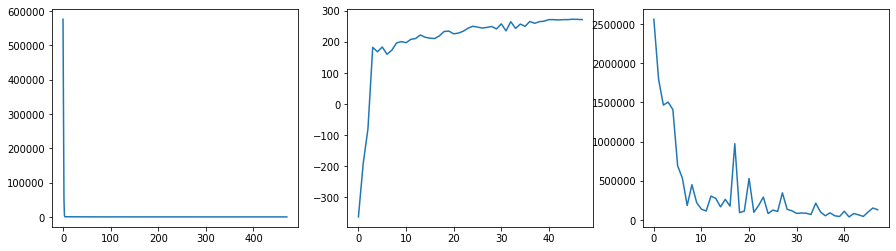

480 | -72.17129516601562 | 272.58453369140625 | 162822.546875


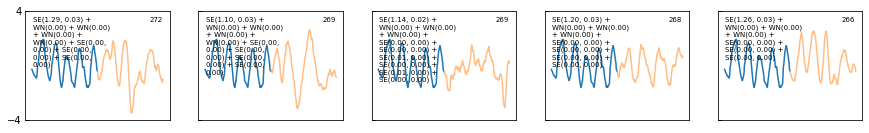

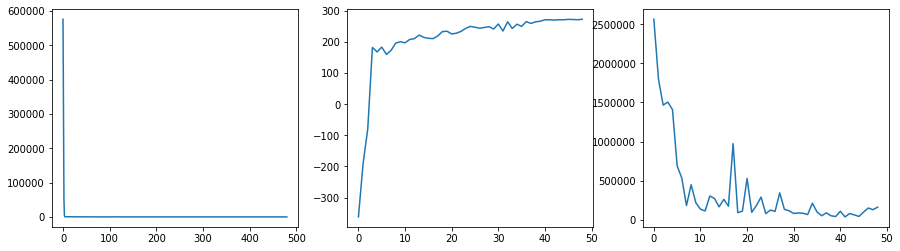

490 | -76.65232849121094 | 271.4561767578125 | 280115.9375


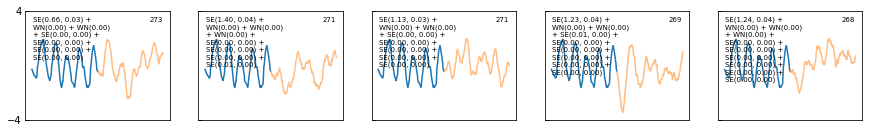

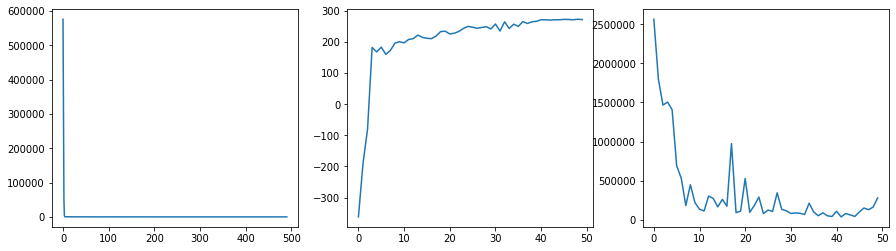

500 | -81.002197265625 | 272.31884765625 | 310123.78125


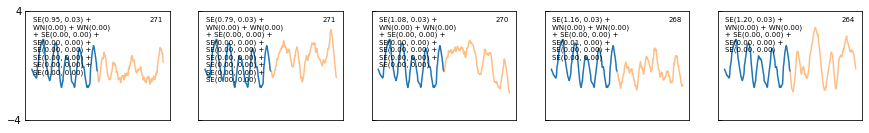

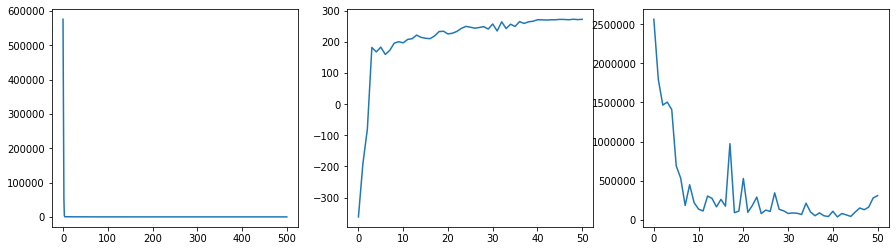

510 | -79.44515991210938 | 272.9822692871094 | 190104.21875


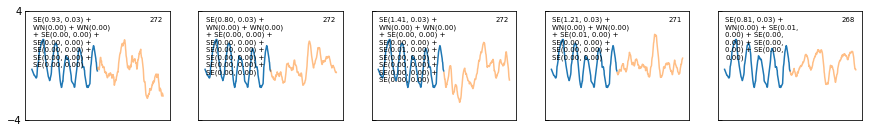

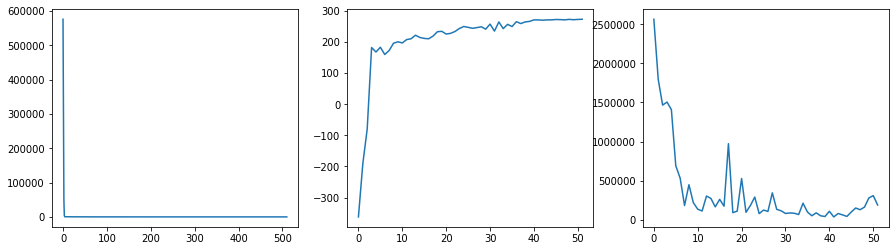

520 | -62.708709716796875 | 273.22100830078125 | 332515.71875


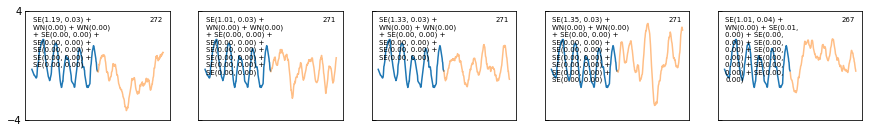

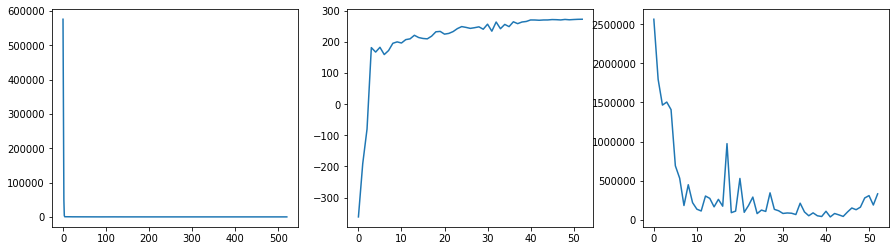

530 | -56.03855895996094 | 272.4908447265625 | 112045.1484375


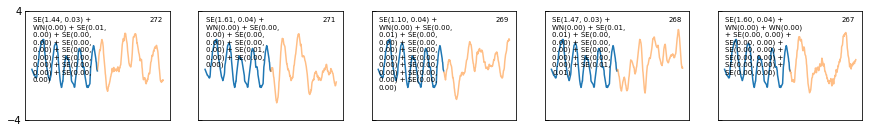

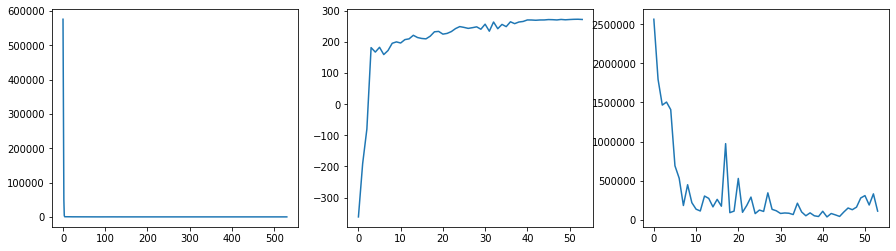

540 | -70.09271240234375 | 272.9722900390625 | 24665.072265625


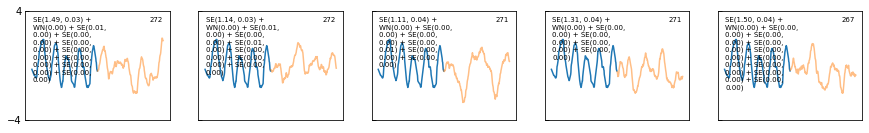

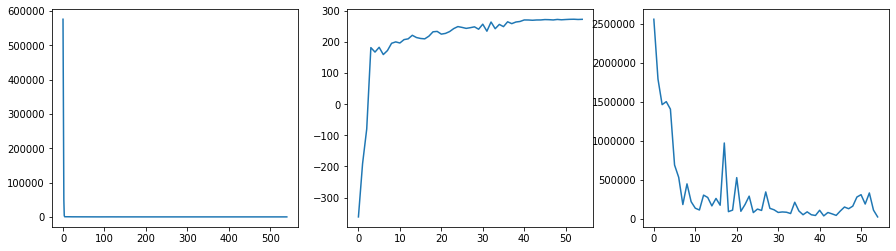

550 | -47.20880126953125 | 272.423095703125 | 69544.09375


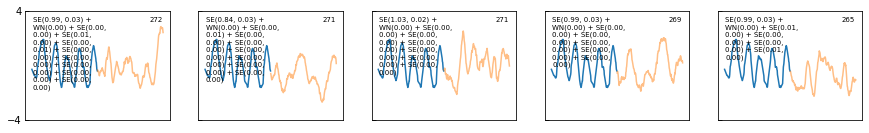

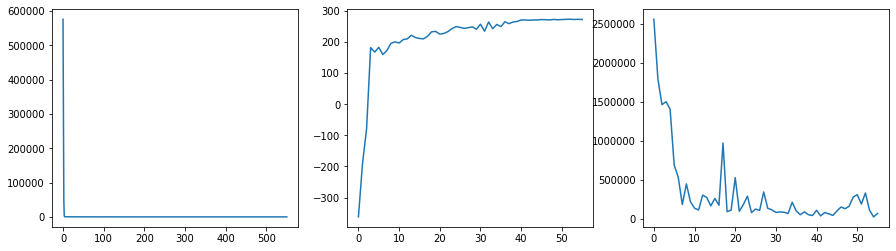

560 | -55.35535430908203 | 273.7749328613281 | 35494.0234375


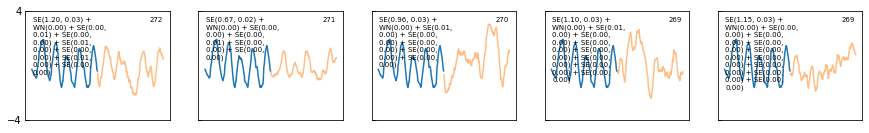

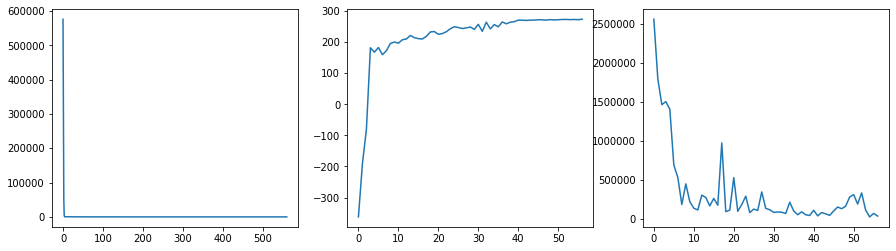

570 | -62.29634094238281 | 273.39202880859375 | 120685.609375


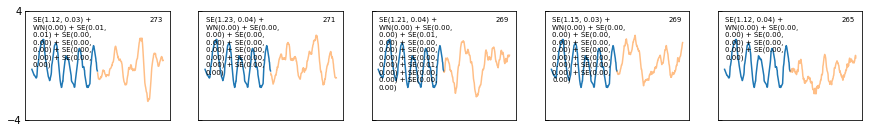

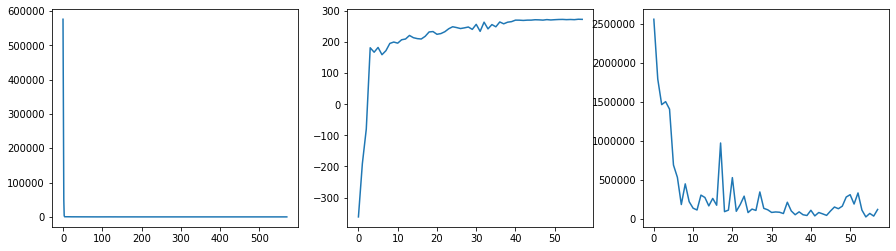

580 | -52.30516815185547 | 273.64886474609375 | 47607.76171875


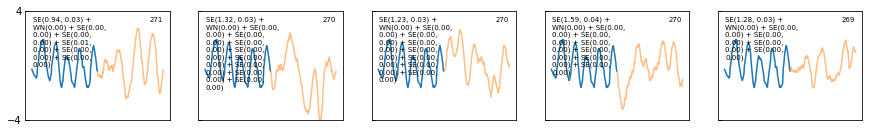

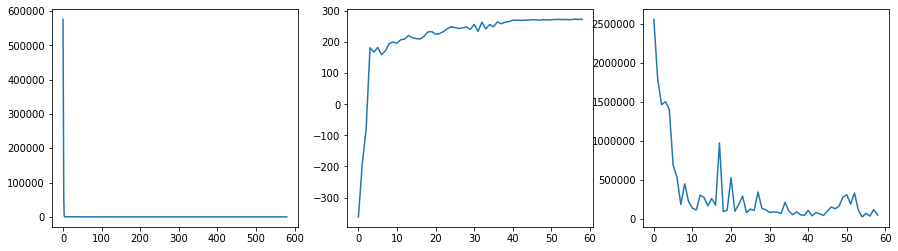

590 | -32.210838317871094 | 265.3341979980469 | 50162.875


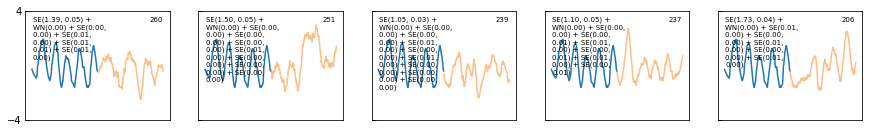

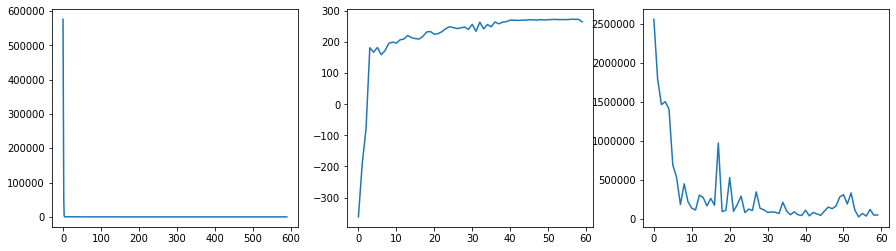

600 | -24.581100463867188 | 268.2697448730469 | 54014.8984375


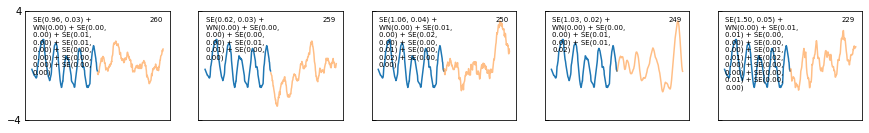

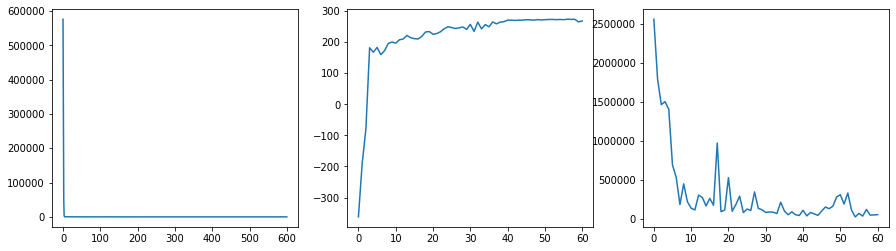

610 | -50.06683349609375 | 268.8729248046875 | 44902.9140625


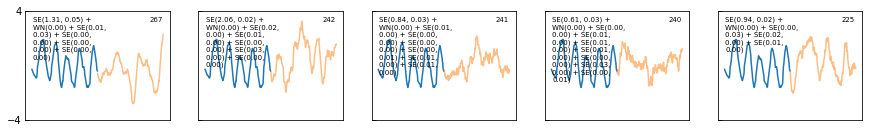

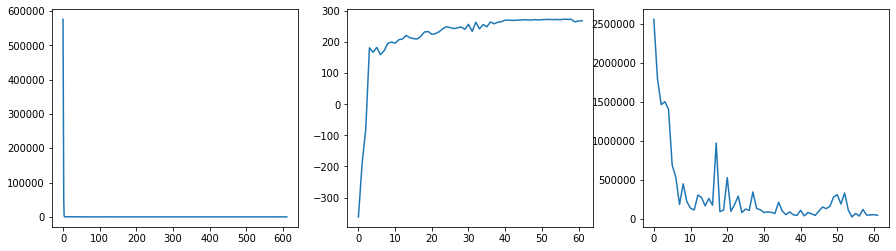

620 | -66.24964904785156 | 270.1010437011719 | 40225.66015625


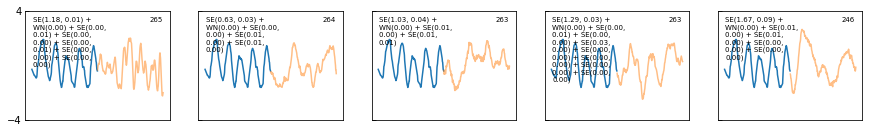

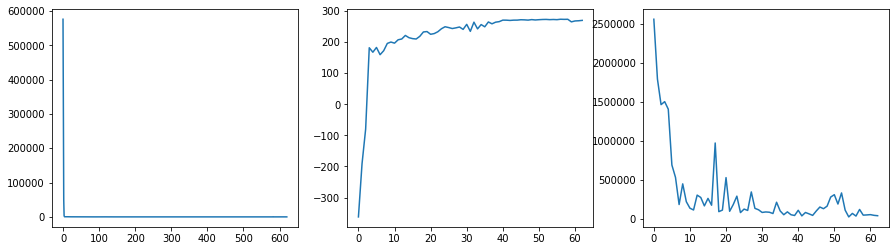

630 | -47.07569885253906 | 270.47186279296875 | 77658.84375


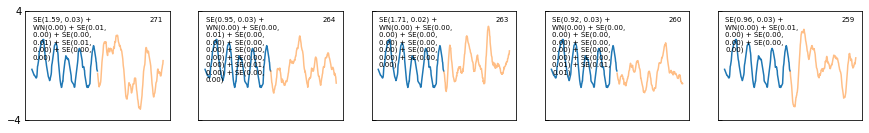

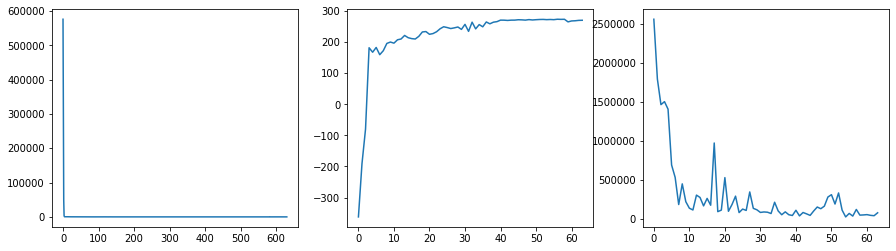

640 | -4.8634490966796875 | 271.4620056152344 | 115520.4765625


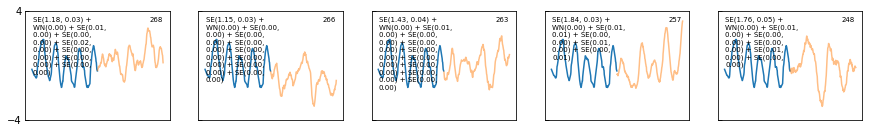

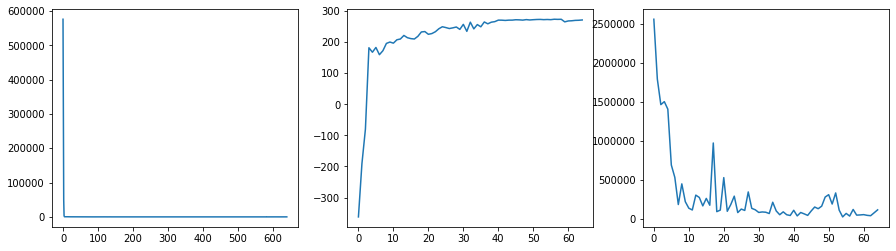

650 | -52.415557861328125 | 271.4440002441406 | 65074.34375


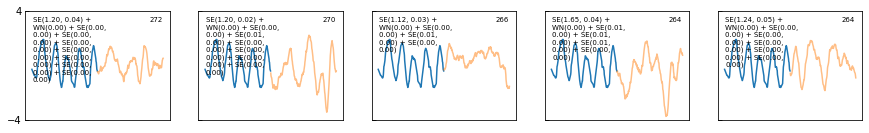

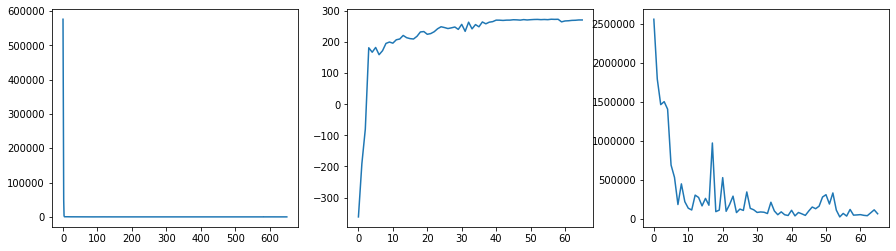

660 | -58.092071533203125 | 271.5419616699219 | 70116.65625


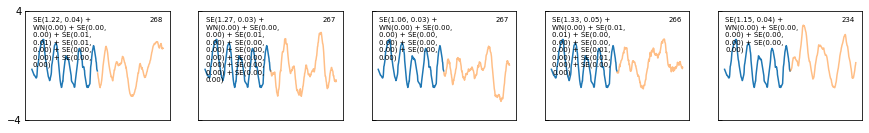

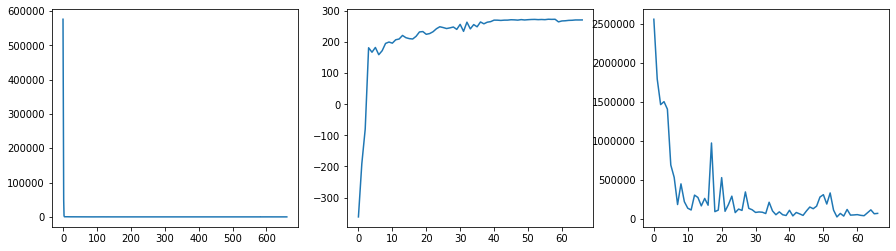

670 | -20.768585205078125 | 272.7046203613281 | 175090.65625


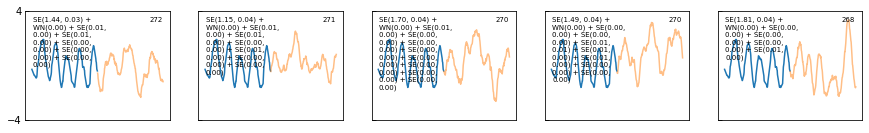

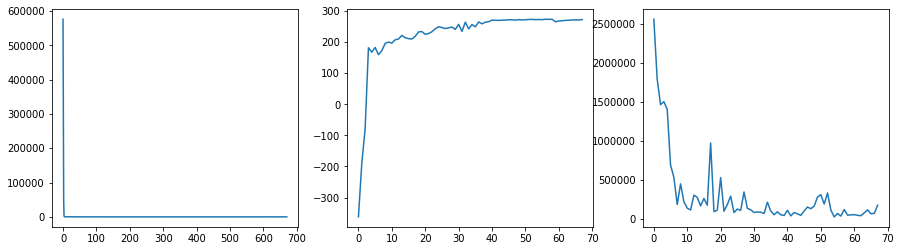

680 | -47.42408752441406 | 272.3951721191406 | 48351.11328125


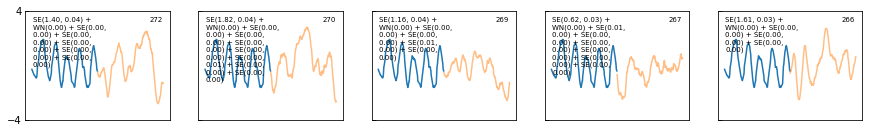

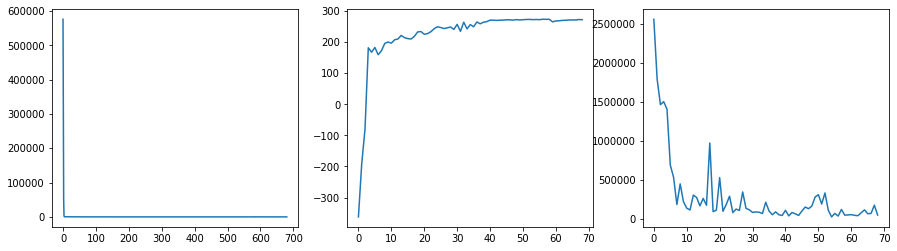

690 | -33.31268310546875 | 272.5990905761719 | 62079.21484375


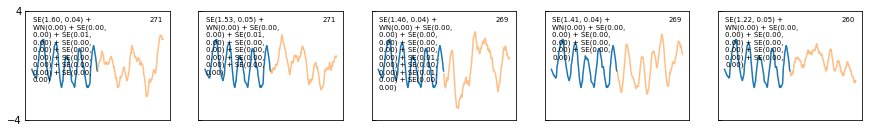

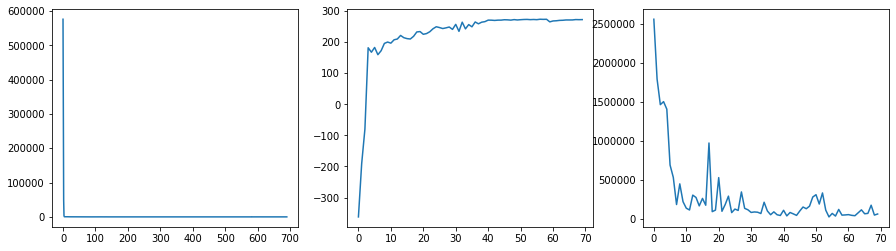

700 | -37.636375427246094 | 273.32958984375 | 91281.40625


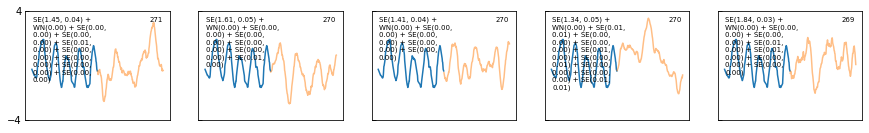

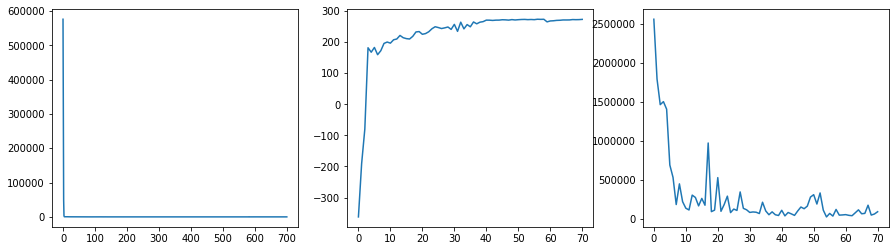

710 | -33.93974304199219 | 273.7189636230469 | 94887.8828125


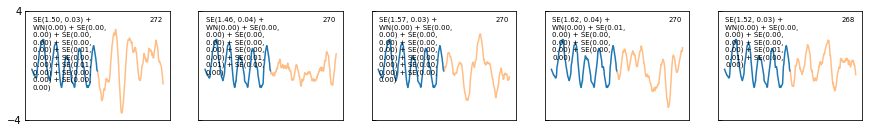

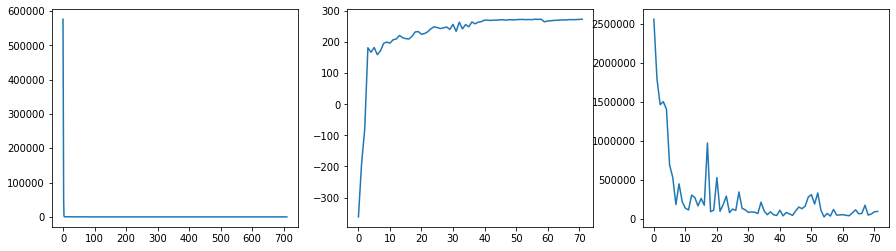

720 | 105.34426879882812 | 273.0291748046875 | 100250.9375


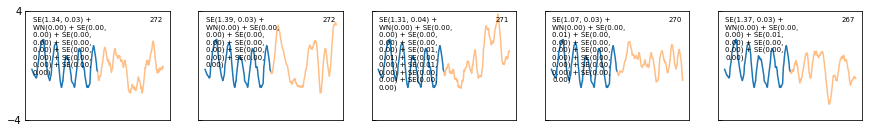

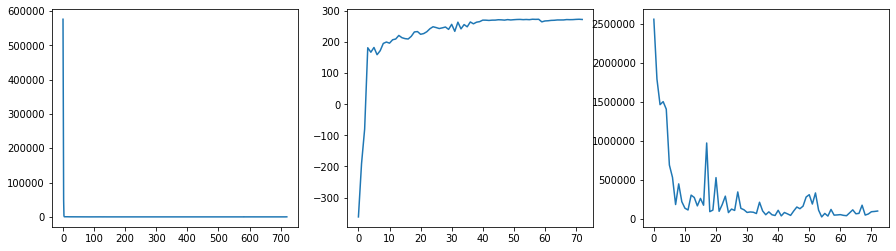

730 | -29.5465087890625 | 273.0644226074219 | 85130.21875


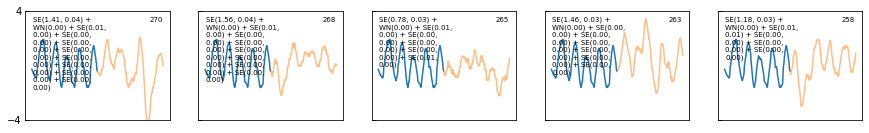

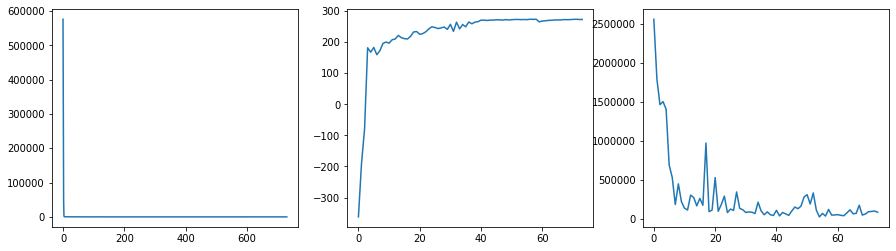

740 | 3.5961456298828125 | 271.94049072265625 | 140164.859375


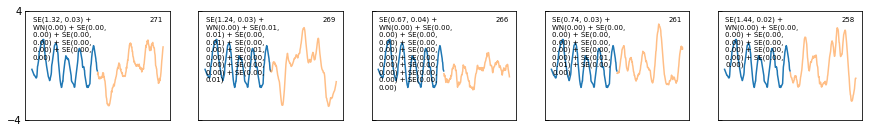

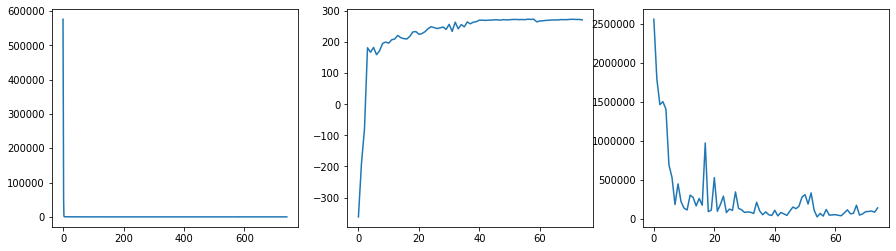

750 | -15.274063110351562 | 272.18890380859375 | 40036.03515625


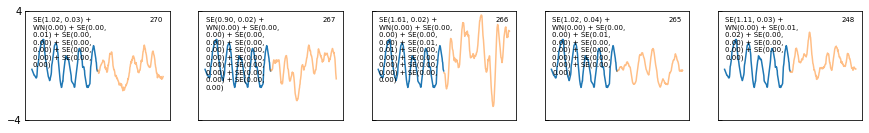

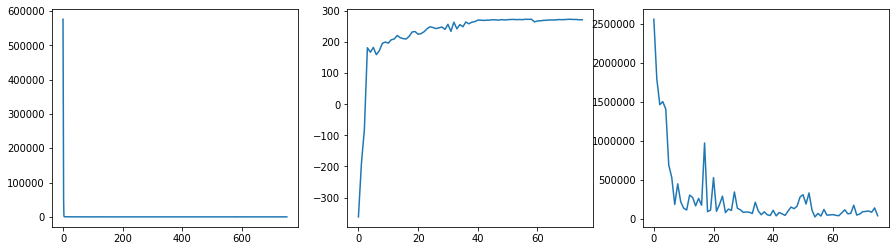

760 | -9.375 | 272.80914306640625 | 120049.609375


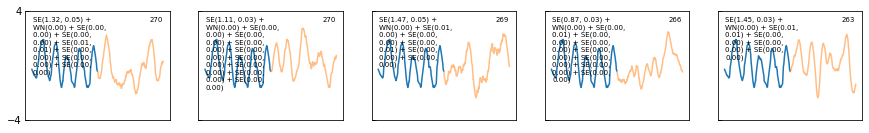

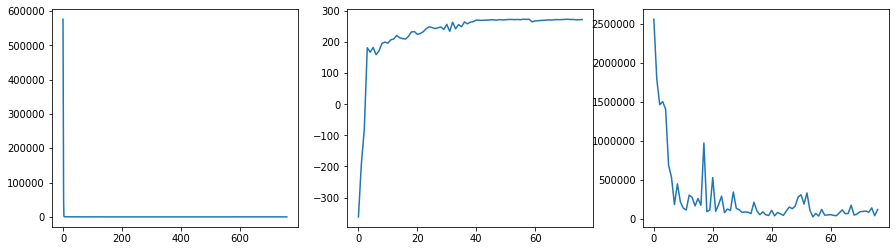

770 | -8.991073608398438 | 272.85552978515625 | 40035.5078125


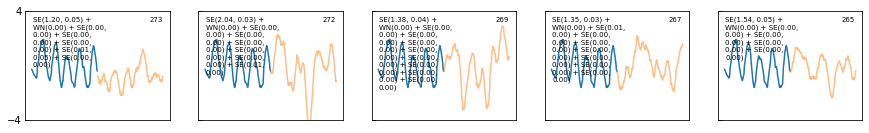

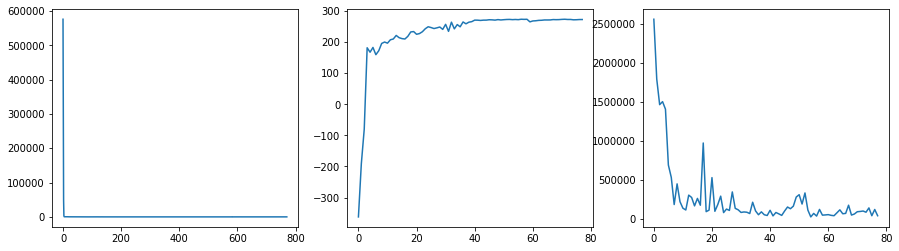

780 | -17.64471435546875 | 272.6009826660156 | 40031.70703125


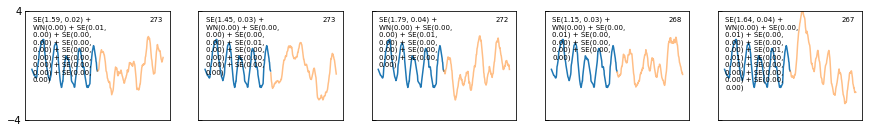

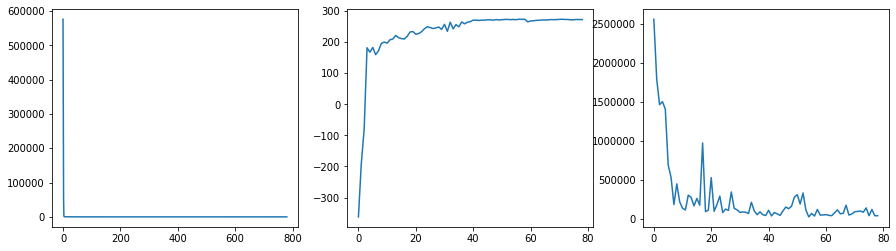

790 | -3.9200897216796875 | 274.18572998046875 | 181046.40625


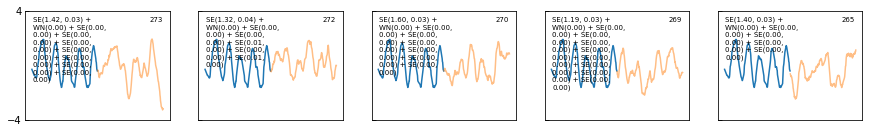

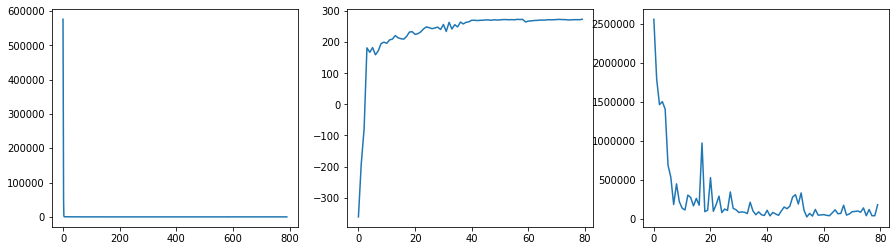

800 | -17.745941162109375 | 272.6700744628906 | 49871.78515625


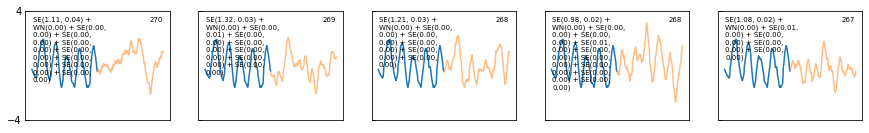

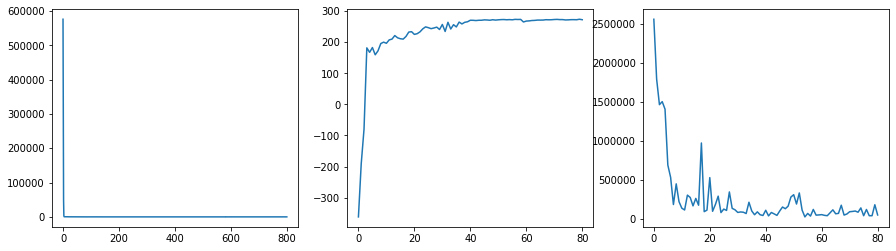

810 | -19.292694091796875 | 272.9749755859375 | 81339.0625


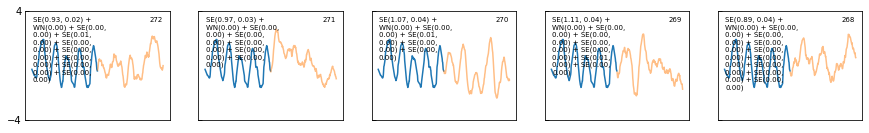

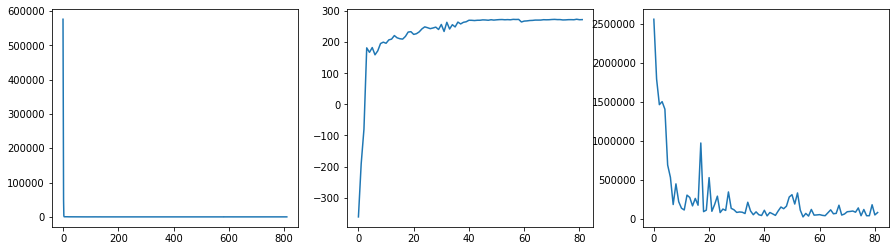

820 | -30.26819610595703 | 273.3948669433594 | 45019.18359375


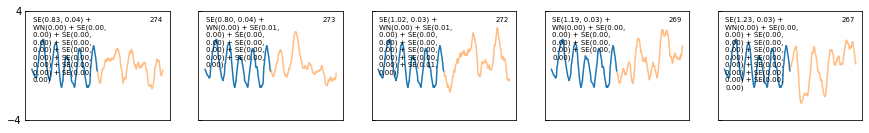

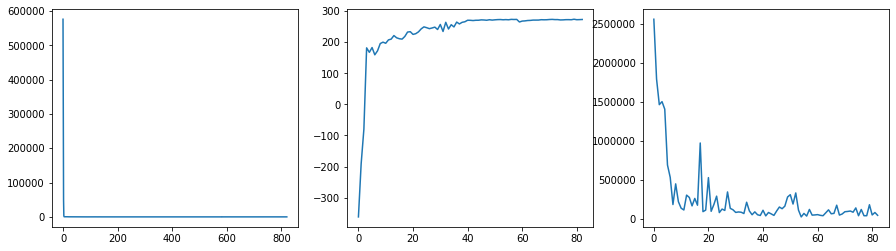

830 | -31.110488891601562 | 273.7827453613281 | 55654.51171875


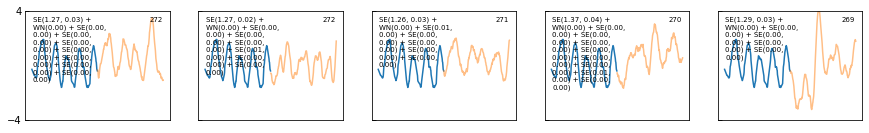

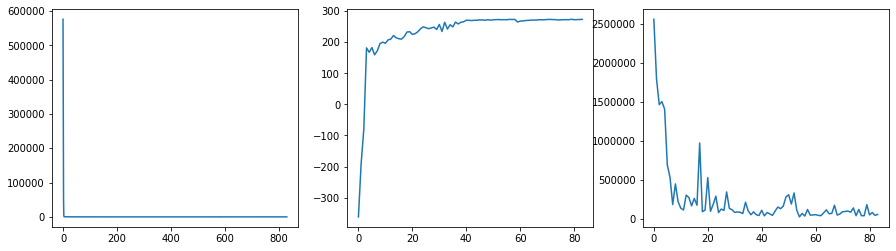

840 | -32.438934326171875 | 273.497314453125 | 65155.82421875


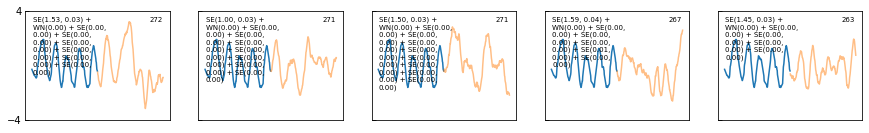

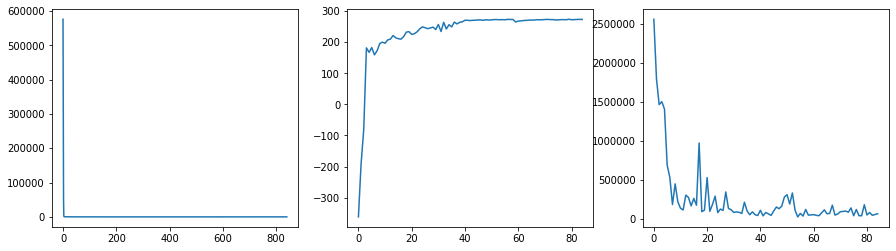

850 | -31.757278442382812 | 273.31585693359375 | 48319.20703125


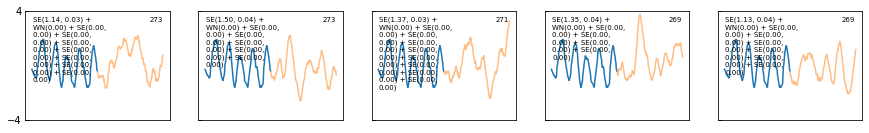

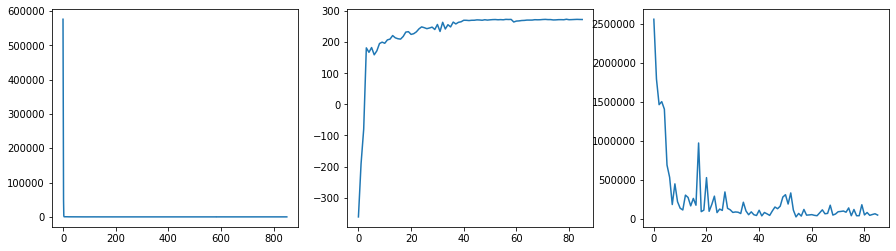

860 | -53.95585632324219 | 273.4627685546875 | 58620.4609375


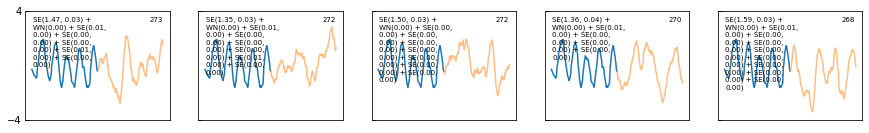

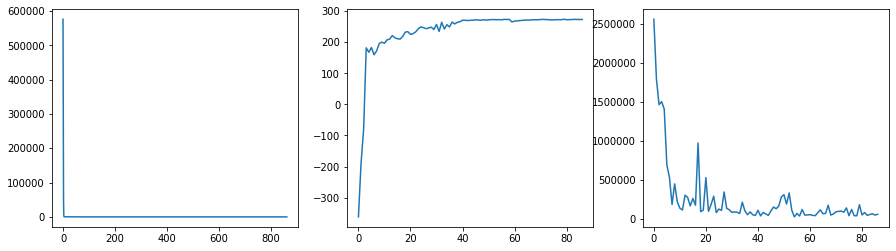

870 | -50.99595642089844 | 273.5901794433594 | 21879.615234375


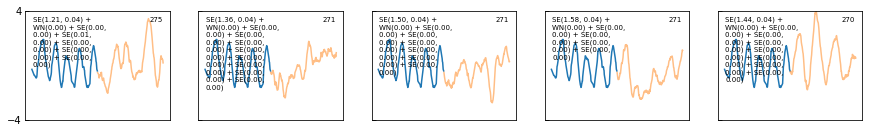

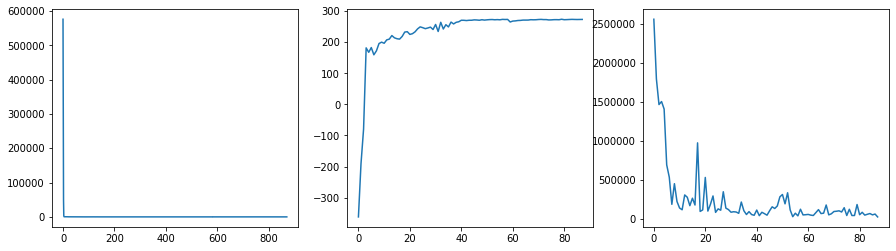

880 | -49.71636962890625 | 272.84722900390625 | 35048.93359375


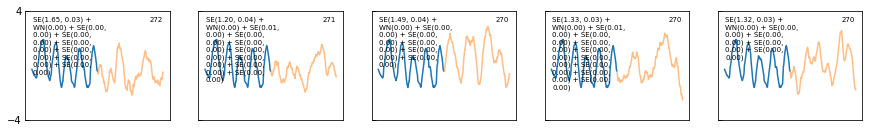

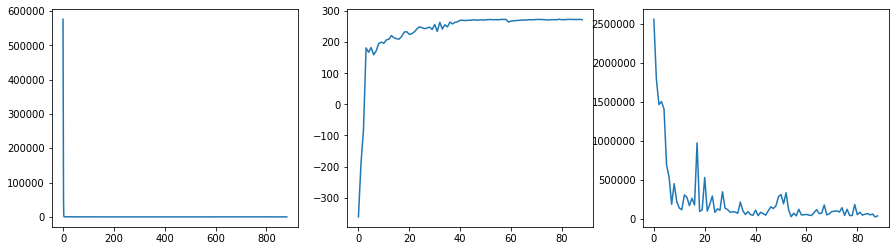

890 | -53.80851745605469 | 272.9466552734375 | 55152.50390625


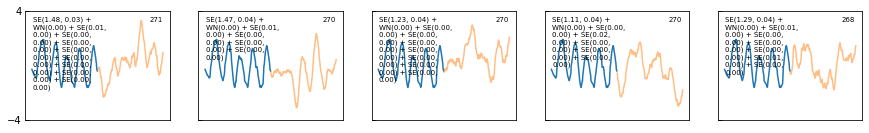

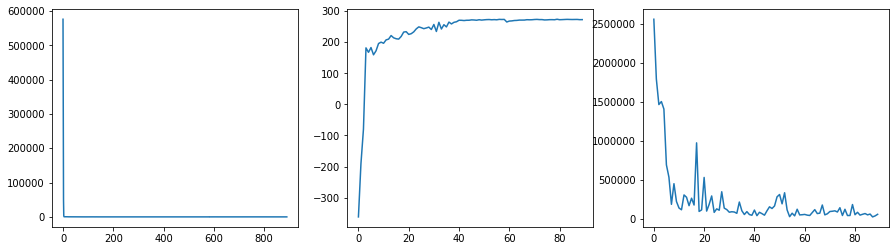

900 | -48.225341796875 | 273.22576904296875 | 25020.75390625


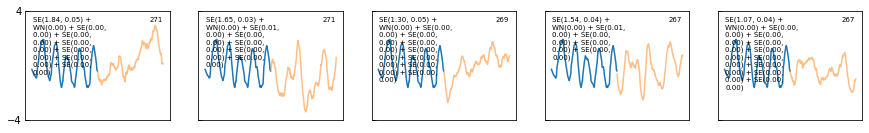

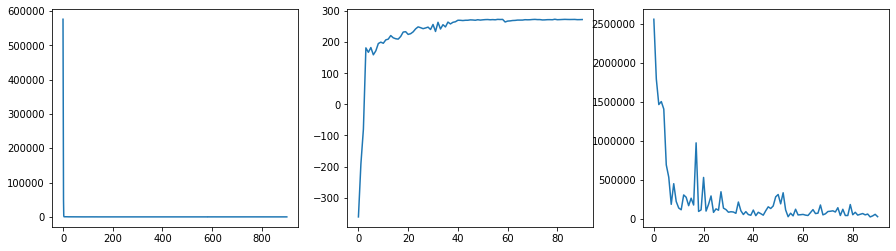

910 | -44.27308654785156 | 273.4396667480469 | 30024.763671875


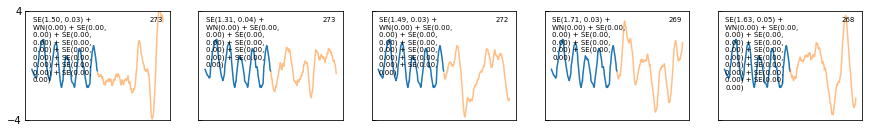

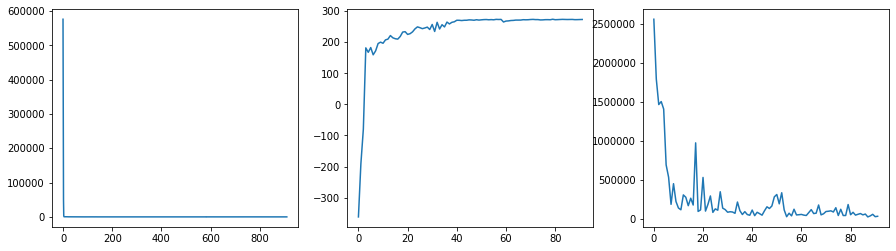

920 | -55.83943176269531 | 274.0174865722656 | 35288.5703125


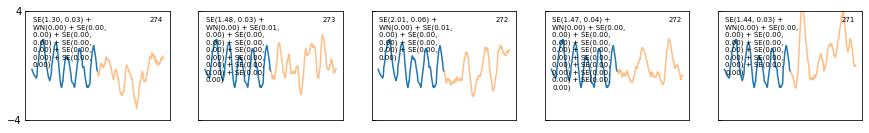

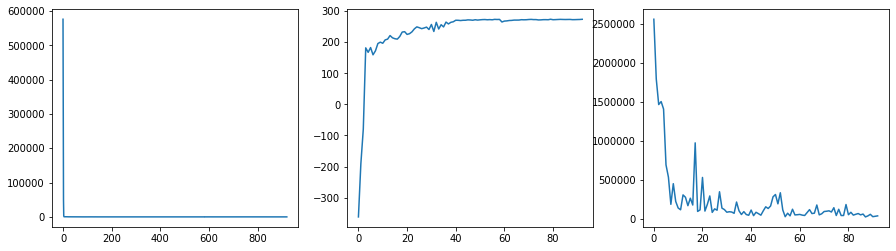

930 | -44.20995330810547 | 273.74169921875 | 40320.27734375


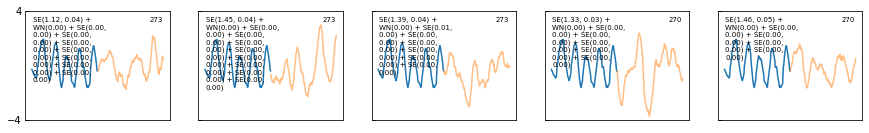

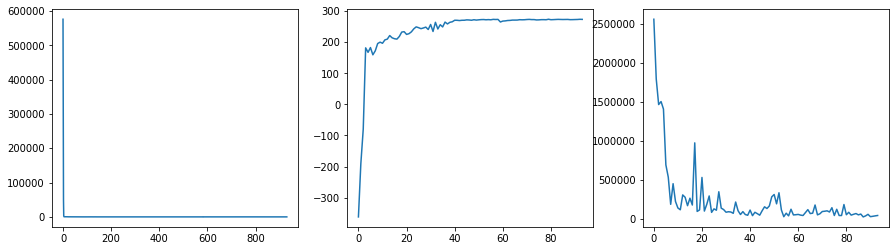

940 | -55.515106201171875 | 273.81182861328125 | 36234.40234375


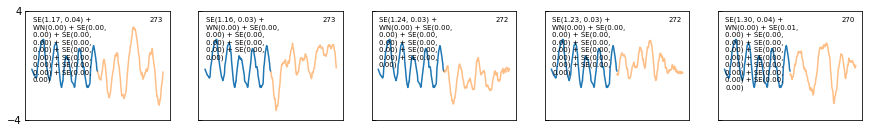

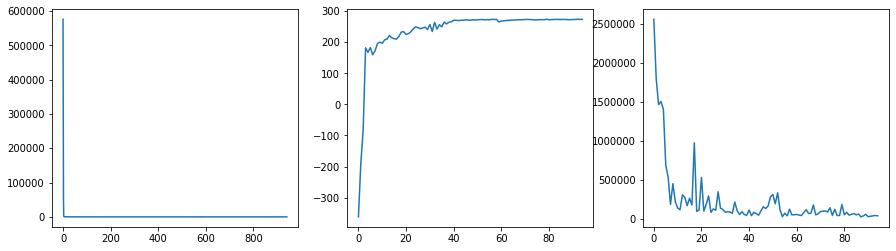

950 | -58.1435546875 | 273.9599304199219 | 35021.61328125


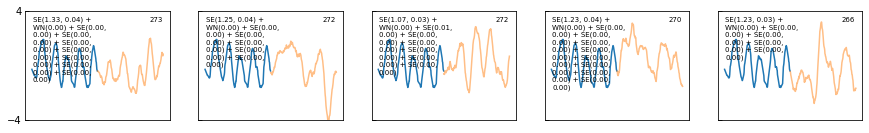

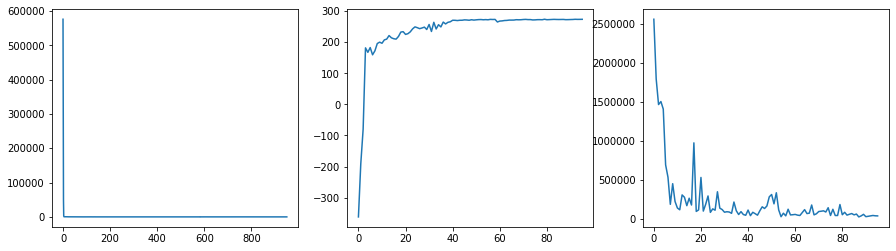

960 | -60.08049011230469 | 273.46734619140625 | 110156.84375


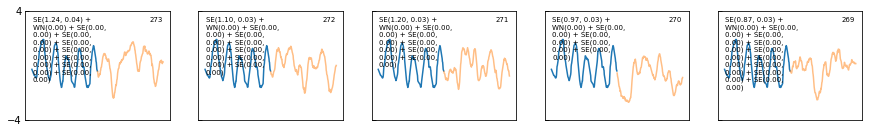

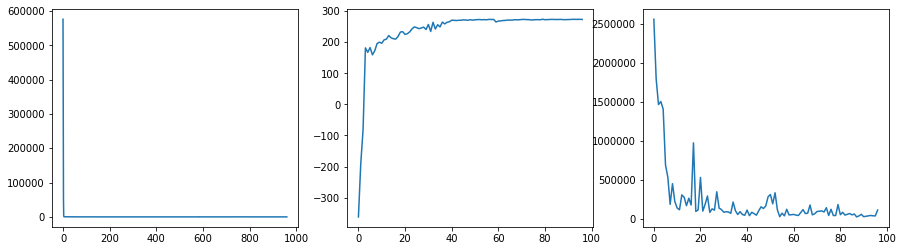

970 | -62.78080749511719 | 273.74365234375 | 25175.01953125


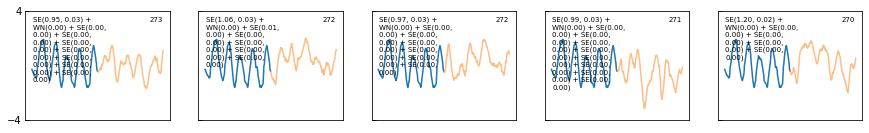

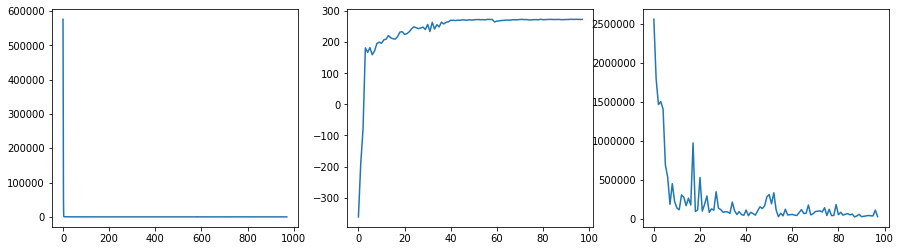

980 | -73.00025939941406 | 273.2347106933594 | 20052.669921875


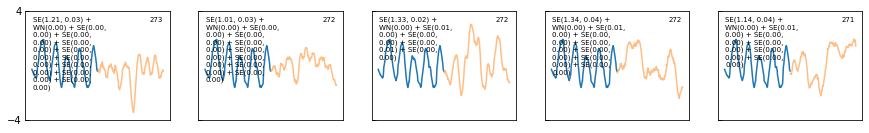

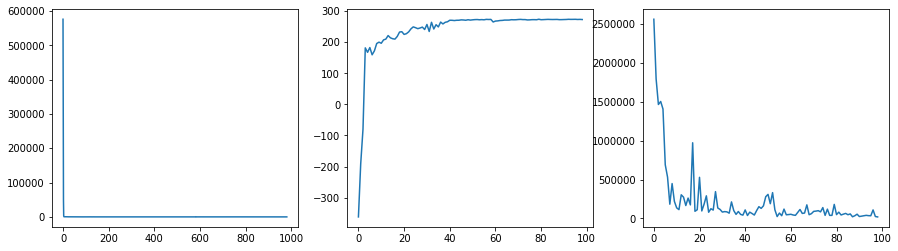

990 | -72.08809661865234 | 273.74761962890625 | 75060.109375


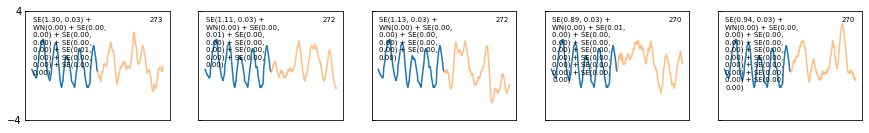

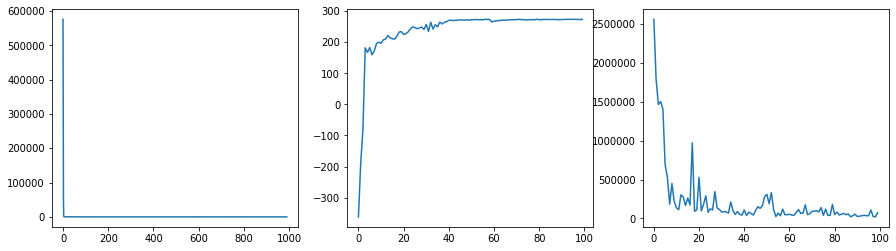

1000 | -70.20476531982422 | 273.7393493652344 | 40689.140625


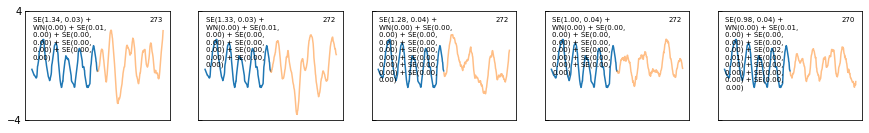

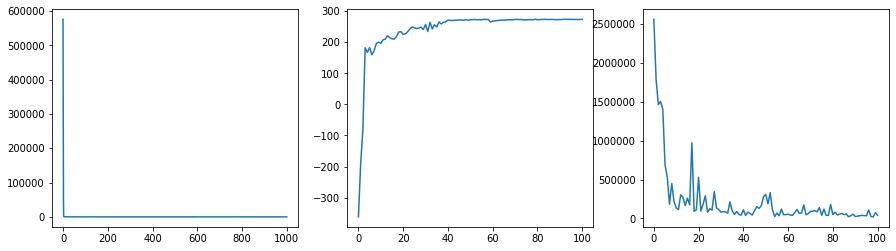

1010 | -75.08741760253906 | 274.2638244628906 | 40019.93359375


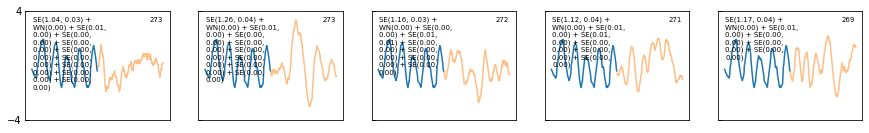

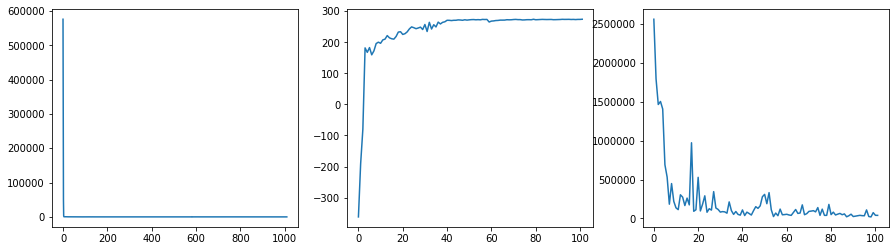

1020 | -76.07098388671875 | 274.2020263671875 | 31286.166015625


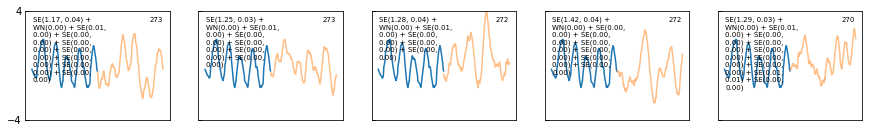

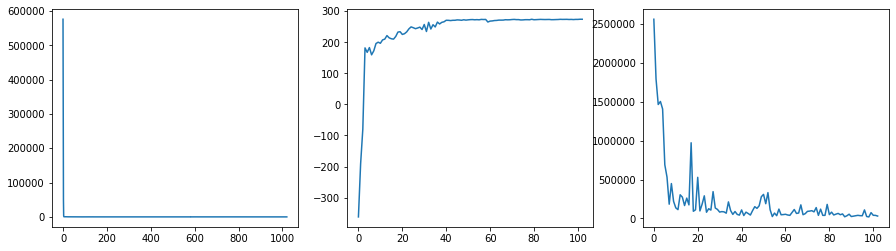

1030 | -78.43997192382812 | 274.4481506347656 | 20119.830078125


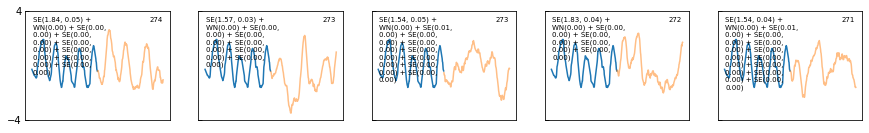

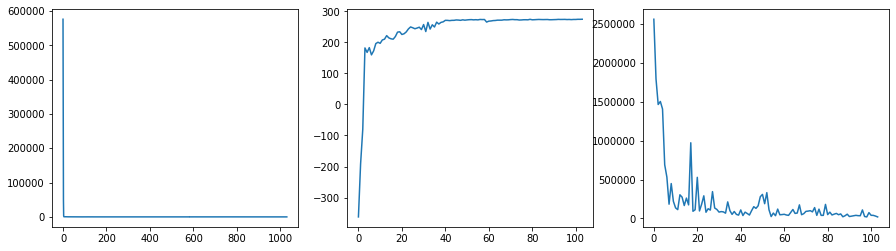

1040 | -71.60697937011719 | 274.1901550292969 | 55033.45703125


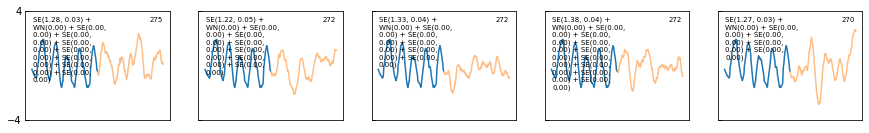

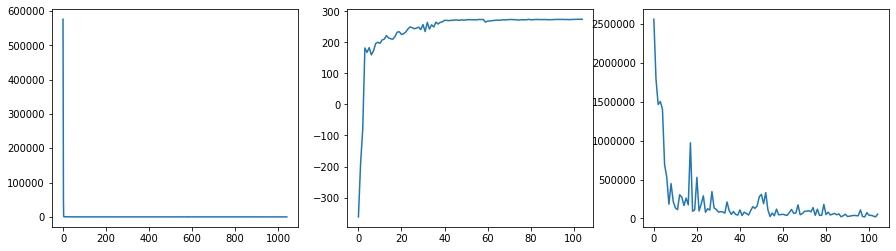

1050 | -71.24234771728516 | 274.1778869628906 | 25025.4453125


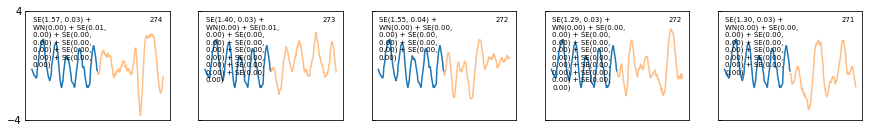

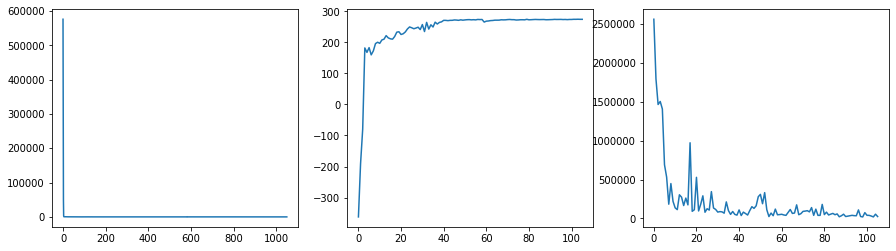

1060 | -77.66511535644531 | 274.1595458984375 | 55764.90234375


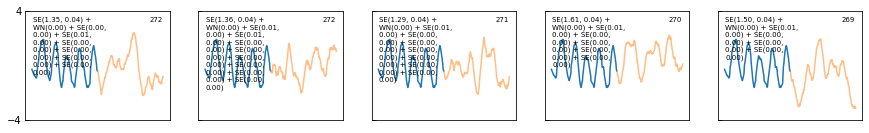

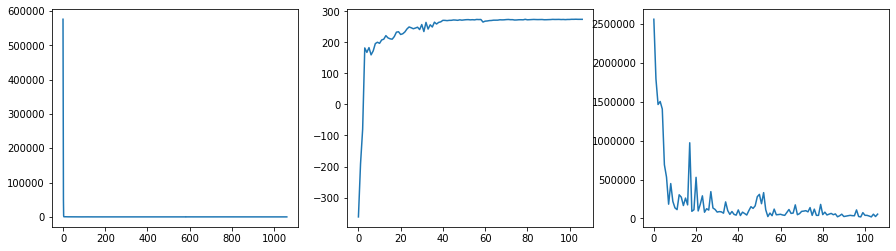

1070 | -64.94071960449219 | 274.22833251953125 | 90694.3359375


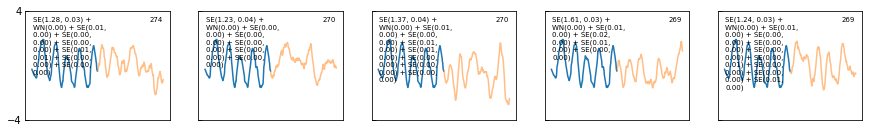

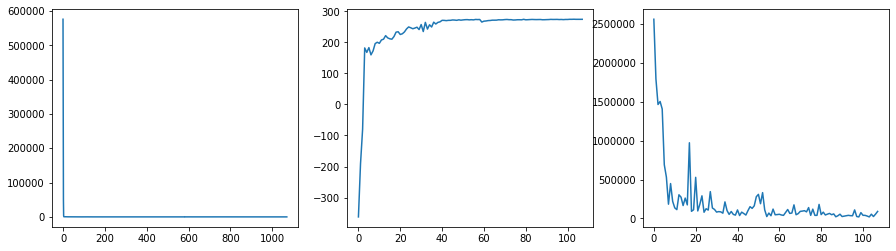

1080 | -81.1727294921875 | 273.9718017578125 | 15650.548828125


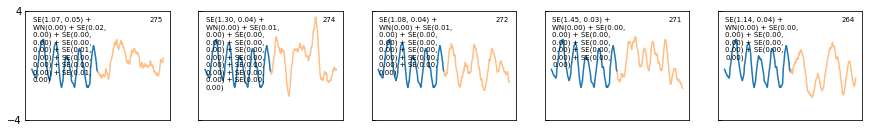

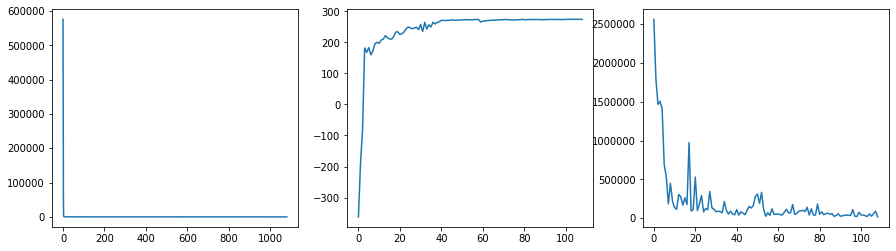

In [ ]:
num_iterations = 100000
losses_, log_p_, kl_ = [], [], []

for i in range(num_iterations):
    # Zero grad
    optimizer.zero_grad()

    if args.algorithm == "cmws":
        loss = losses.get_cmws_loss(
            generative_model,
            guide,
            memory,
            obs,
            obs_id,
            args.num_particles,
            args.num_proposals_mws,
            insomnia=args.insomnia,
        ).mean()
    if args.algorithm == "cmws_2":
        loss = losses.get_cmws_2_loss(
            generative_model,
            guide,
            memory,
            obs,
            obs_id,
            args.num_particles,
            args.num_proposals_mws,
            insomnia=args.insomnia,
        ).mean()
    elif args.algorithm == "rws":
        loss = losses.get_rws_loss(
            generative_model,
            guide,
            obs,
            args.num_particles,
            insomnia=args.insomnia,
        )

    # Compute gradient
    loss.backward()

    # Step gradient
    optimizer.step()
    losses_.append(loss.item())
    
    if i % 10 == 0:
        log_p, kl = losses.get_log_p_and_kl(generative_model, guide, obs, 200)
        log_p_.append(log_p.item())
        kl_.append(kl.item())
        print(f"{i} | {losses_[-1]} | {log_p_[-1]} | {kl_[-1]}")
        plot_predictions_timeseries(generative_model, guide, obs, memory, obs_id)
        plt.show()
        fig, axs = plt.subplots(1, 3, figsize=(15, 4))
        axs[0].plot(losses_)
        axs[1].plot(log_p_)
        axs[2].plot(kl_)
        plt.show()


# Trying to further optimize continuous params using gradient descent

In [ ]:
raw_expression, eos, gp_raw_params = guide.sample(obs[0])
get_full_expression(raw_expression, eos, gp_raw_params)

In [ ]:
# gp_raw_params_opt = gp_raw_params.clone().detach().requires_grad_(True)
gp_raw_params_opt = torch.randn(gp_raw_params.shape, device=device, requires_grad=True)
opt = torch.optim.Adam([gp_raw_params_opt])


losss = []
num_iterations = 10000
for i in range(num_iterations):
    opt.zero_grad()
    loss = -get_obs_log_prob(raw_expression, eos, gp_raw_params_opt, obs).sum()
    loss.backward()
    opt.step()
    losss.append(loss.item())
    if i % 100 == 0:
        print(f"{i} | {losss[-1]}")
        plt.plot(losss)
        plt.show()
        print(get_full_expression(raw_expression, eos, gp_raw_params_opt))

In [ ]:
obs_predictions = generative_model.sample_obs_predictions((raw_expression, eos, gp_raw_params_opt), obs[0])